# SBB DATA ANALYSIS

This notebook analyzes SBB data.

In this notebook we analyse, profile and clean SBB dataset. Moreover, we analyse delays of transportation vehicles and their relations with other features in the dataset.

Following data structures created and saved as json file:
- ACTUAL_ARRIVE_TIME_hour
- ACTUAL_ARRIVE_TIME_week_day
- ACTUAL_ARRIVE_TIME_month

- ACTUAL_DEPART_TIME_hour
- ACTUAL_DEPART_TIME_week_day
- ACTUAL_DEPART_TIME_month
- OPERATOR_ID
- SERVICE_TYPE
- STATION_ID

### Dependencies

In [1]:
import os
import re
import pickle
import getpass
import math

import pyspark.sql.functions as F
from pyspark.sql.functions import unix_timestamp, udf, desc, countDistinct
import ast
import numpy as np
from scipy import stats
import pandas as pd
import networkx as nx
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

import spark_df_profiling

import random
import json
import matplotlib.patches as mpatches
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler,Normalizer,  PCA,VectorIndexer
from pyspark.ml.clustering import KMeans, BisectingKMeans, GaussianMixture

Change Layout to be able to see spark dataframes

In [2]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [4]:
%matplotlib inline
import matplotlib.pylab as plt

plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')

### Spark Setup

In [3]:
username = getpass.getuser()

if username == "jbanjac":
    ROOT_PATH = "/home/jbanjac/robust-journey-planning"
    os.environ['PYSPARK_PYTHON'] = '/opt/anaconda3/bin/python'
elif username == "jelena":
    ROOT_PATH = "/home/jelena/Desktop/2-semester/4-LabInDS/Project/robust-journey-planning"
    os.environ['PYSPARK_PYTHON'] = '/home/jelena/anaconda3/bin/python'
else:
    raise RuntimeError("Please specify your ROOT_PATH to the project")

In [5]:
if username == "jelena":
    spark = (SparkSession \
                .builder \
                .appName('sbb-{0}'.format(getpass.getuser())) \
                .master('local[4]') \
                .config('spark.driver.memory', '10g') \
                .config('spark.executor.memory', '4g') \
                .config('spark.executor.instances', '5') \
                .config('spark.port.maxRetries', '100') \
                .getOrCreate())
    CLUSTER_URL = "hdfs://iccluster042.iccluster.epfl.ch:8020"
else:
    spark = SparkSession \
                .builder \
                .master("yarn") \
                .appName('sbb-{0}'.format(getpass.getuser())) \
                .config('spark.executor.memory', '4g') \
                .config('spark.executor.instances', '5') \
                .config('spark.port.maxRetries', '100') \
                .getOrCreate()
    CLUSTER_URL = ""

sc = spark.sparkContext
conf = sc.getConf()

spark

## SBB Data

Read CSV files (Column descriptions could be found [here](https://opentransportdata.swiss/de/cookbook/ist-daten/).)

In [7]:
df = spark.read.csv(f"{CLUSTER_URL}/datasets/sbb/*/*/*.csv.bz2", sep=';', header=True).cache()

In [8]:
df = df.withColumnRenamed("BETRIEBSTAG", "TRIP_DATE")\
       .withColumnRenamed("FAHRT_BEZEICHNER", "TRIP_ID")\
        .withColumnRenamed("BETREIBER_ID", "OPERATOR_ID")\
        .withColumnRenamed("BETREIBER_ABK", "OPERATOR_ABK")\
        .withColumnRenamed("BETREIBER_NAME", "OPERATOR_NAME")\
        .withColumnRenamed("PRODUKT_ID", "TRANSPORT_TYPE")\
        .withColumnRenamed("LINIEN_ID", "TRAIN_ID")\
        .withColumnRenamed("LINIEN_TEXT", "TRAIN_NAME")\
        .withColumnRenamed("UMLAUF_ID", "CIRCULATING_ID")\
        .withColumnRenamed("VERKEHRSMITTEL_TEXT", "SERVICE_TYPE")\
        .withColumnRenamed("ZUSATZFAHRT_TF", "ADDITIONAL_DRIVING")\
        .withColumnRenamed("FAELLT_AUS_TF", "FAILED")\
        .withColumnRenamed("BPUIC", "STATION_ID")\
        .withColumnRenamed("HALTESTELLEN_NAME", "STATION_NAME")\
        .withColumnRenamed("ANKUNFTSZEIT", "SCHEDULE_ARRIVE_TIME")\
        .withColumnRenamed("AN_PROGNOSE", "ACTUAL_ARRIVE_TIME")\
        .withColumnRenamed("AN_PROGNOSE_STATUS", "ACTUAL_ARRIVE_TIME_STATUS")\
        .withColumnRenamed("ABFAHRTSZEIT", "SCHEDULE_DEPART_TIME")\
        .withColumnRenamed("AB_PROGNOSE", "ACTUAL_DEPART_TIME")\
        .withColumnRenamed("AB_PROGNOSE_STATUS", "ACTUAL_DEPART_TIME_STATUS")\
        .withColumnRenamed("DURCHFAHRT_TF", "PASSES_BY")

In [9]:
df.printSchema()

root
 |-- TRIP_DATE: string (nullable = true)
 |-- TRIP_ID: string (nullable = true)
 |-- OPERATOR_ID: string (nullable = true)
 |-- OPERATOR_ABK: string (nullable = true)
 |-- OPERATOR_NAME: string (nullable = true)
 |-- TRANSPORT_TYPE: string (nullable = true)
 |-- TRAIN_ID: string (nullable = true)
 |-- TRAIN_NAME: string (nullable = true)
 |-- CIRCULATING_ID: string (nullable = true)
 |-- SERVICE_TYPE: string (nullable = true)
 |-- ADDITIONAL_DRIVING: string (nullable = true)
 |-- FAILED: string (nullable = true)
 |-- STATION_ID: string (nullable = true)
 |-- STATION_NAME: string (nullable = true)
 |-- SCHEDULE_ARRIVE_TIME: string (nullable = true)
 |-- ACTUAL_ARRIVE_TIME: string (nullable = true)
 |-- ACTUAL_ARRIVE_TIME_STATUS: string (nullable = true)
 |-- SCHEDULE_DEPART_TIME: string (nullable = true)
 |-- ACTUAL_DEPART_TIME: string (nullable = true)
 |-- ACTUAL_DEPART_TIME_STATUS: string (nullable = true)
 |-- PASSES_BY: string (nullable = true)



Filter Data by stations around Zurich

In [15]:
 # load station ids in Zurich
with open('distance/station_ids.pickle', 'rb') as handle:
    station_ids = pickle.load(handle)
    
# load Zurich stations set
with open('distance/zurich_stations_set.pickle', 'rb') as handle:
    zurich_stations_set = pickle.load(handle)

In [14]:
df_zurich = df.where(F.col("station_id").isin(zurich_stations_set)).cache()

### Profiling of Zurich Dataframe

We use [Spark DataFrames Profiling](https://github.com/julioasotodv/spark-df-profiling).

In [19]:
report = spark_df_profiling.ProfileReport(df_zurich)
# report.to_file("report.html")
report

## Observations

What we discovered from the profiling is the following:

##### General
- `TRIP_ID` is not unique, it sometimes has even more than 7600 intances.
- `TRIP_DATE` has 505 unique values, which corresponds to our range from 13.09.2017 to 31.01.2019, 505 days. _Random Info_: Interesting fact is that the highest amout of trips was on 31.12.2018, a lot of people traveled on a New Year's Eve.
- `OPERATOR_ID`, `OPERATOR_ABK`, `OPERATOR_NAME` all have 13 related unique values.
- `TRANSPORT_TYPE` has 3 unique values and some missing values:
    - missing: 1873
    - **57.6%** of buses
    - **37.3%** of trams
    - **5.1%** of trains
- `TRAIN_ID` and `TRAIN_NAME` don't have the same number of unique values. The TRAIN_NAME has 240 unique values and TRAIN_ID has 5921. This means that several different trains have the same name.
- `CIRCULATION_ID` = If the transport company transmits circulations, the circulation ID is filled in here. It has **5.1%** of missing values. We probably don't need this information for our study.
- `SERVICE_TYPE` has **42.5%** of data missing. Otherwise, it has 26 unique values: Bus, Trm, other (IC, R, etc. probably train types).
- `ADDITIONAL_DRIVING` has 2 unique values. True (**1%**) = it is an additional trip that is not part of regular schedule, False (**99%**) = this is not an additional trip.
- `FAILED` has 2 unique values. True (**1%**) = trip is cancelled, False (**99%**) = trip is not cancelled
- `STATION_ID` we have 1005 unique station IDs, STATION_NAME has 1647 unique values. This is a bit odd since this means that same station ID can have several different names. Both of them don't have any missing values.
- `PASSES_BY` has 2 unique values and 1 missing. True (**0.2%**) = passed by, False (**99.8%**) = stopped at this station.


##### Arrive

`SCHEDULE_ARRIVE_TIME` = The target arrival time at the stop rounded to minutes.
- missing 5.8% (7348278)
- unique 0.5% (658006)

`ACTUAL_ARRIVE_TIME` = `[FORECAST TIME]` The forecast of arrival without rounding. Note: It is possible that a transport company has already performed the rounding itself and therefore the seconds are not available.
- missing 6% (7634127)
- unique 27.7% (33100315)

`ACTUAL_ARRIVE_TIME_STATUS`
- 4 unique values:
	- PROGNOSE (**95.3%**) = arrival forecast
	- REAL (**2.4%**) = actual arrival time
	- GESCHAETZT (**2.1%**) = STATED, calculated actual arrival time, use ACTUAL_ARRIVE_TIME
	- UNBEKANNT (**0.2%**) = UNKNOWN, no forecast and actual times available for this and previous stops
- 1 missing value **TODO: check this one missing?** _In [here](https://opentransportdata.swiss/de/cookbook/ist-daten/) they said if it is empty, that means this one is PROGNOSE._


##### Depart

`SCHEDULE_DEPART_TIME` = The target departure time from the stop rounded to minutes.
- missing 5.8% (7358719) a bit more than in arrive part
- unique 0.5% (657987) a bit less than in arrive part

`ACTUAL_DEPART_TIME` = `[FORECAST TIME]` The forecast of departure without rounding. Note: It is possible that a transport company has already performed the rounding itself and therefore the seconds are not available.
- missing 6% (7644900) a bit more
- unique 27.4% (32776064) a bit less

`ACTUAL_ARRIVE_TIME_STATUS`
- 4 unique values:
	- PROGNOSE (**95.3%**) = depart forecast
	- REAL (**2.5%**) = actual depart time
	- GESCHAETZT (**2.1%**) = STATED, calculated actual depart time, use ACTUAL_DEPART_TIME
	- UNBEKANNT (**0.2%**) = UNKNOWN, no forecast and actual times available for this and previous stops
- 1 missing value **TODO: check this one missing?** _In [here](https://opentransportdata.swiss/de/cookbook/ist-daten/) they said if it is empty, that means this one is PROGNOSE._


Therefore:

UNBEKANNT 
- when schedule is known (SCHEDULE_DEPART_TIME), but actual/forecast one is null always (ACTUAL_DEPART_TIME); therefore, we don't know if it was late or not.

PROGNOSE 
- records with PROGNOSE are with stops where no control technology data is yet available
- records with PROGNOSE receive actual times based on the forecast times of operational planning system of SBB
- the inaccuracies are possible and neglibible
- can happen that both actual and scheduled time are null

REAL
- actual ACTUAL_ARRIVE_TIME 

GESCHAETZT 
- records with GESCHAETZT are estimated actual times based on the control technology data.
- this records should not report the departure of train to us before the scheduled departure time.




Status could be seen bellow:
![](images/statuses.png)

## Data Analysis and Cleaning

#### Trip ID

From below, we can see that with TRIP_ID = 85:849:104711-01912-1 we get that it is only a bus that goes 24 times each day. Actually, it is active 7632/24 = 318 days. Which is around working on working days. 

In [19]:
df_zurich.filter(df_zurich.TRIP_ID == '85:849:104711-01912-1').groupBy('TRIP_ID','TRANSPORT_TYPE').count().show()

+--------------------+--------------+-----+
|             TRIP_ID|TRANSPORT_TYPE|count|
+--------------------+--------------+-----+
|85:849:104711-019...|           Bus| 7632|
+--------------------+--------------+-----+



In [20]:
df_zurich.filter(df_zurich.TRIP_ID == '85:849:104711-01912-1').groupBy('TRIP_ID', 'TRIP_DATE').count().show()

+--------------------+----------+-----+
|             TRIP_ID| TRIP_DATE|count|
+--------------------+----------+-----+
|85:849:104711-019...|10.12.2018|   24|
|85:849:104711-019...|11.07.2018|   24|
|85:849:104711-019...|20.12.2018|   24|
|85:849:104711-019...|06.07.2018|   24|
|85:849:104711-019...|13.07.2018|   24|
|85:849:104711-019...|11.10.2018|   24|
|85:849:104711-019...|12.10.2018|   24|
|85:849:104711-019...|18.06.2018|   24|
|85:849:104711-019...|23.11.2017|   24|
|85:849:104711-019...|27.08.2018|   24|
|85:849:104711-019...|21.09.2017|   24|
|85:849:104711-019...|16.08.2018|   24|
|85:849:104711-019...|15.08.2018|   24|
|85:849:104711-019...|21.03.2018|   24|
|85:849:104711-019...|07.06.2018|   24|
|85:849:104711-019...|05.06.2018|   24|
|85:849:104711-019...|07.11.2018|   24|
|85:849:104711-019...|20.02.2018|   24|
|85:849:104711-019...|07.02.2018|   24|
|85:849:104711-019...|01.02.2018|   24|
+--------------------+----------+-----+
only showing top 20 rows



#### TRANSPORT_TYPE

We remove records that have missing TRANSPORT_TYPE

In [17]:
df_zurich = df_zurich.filter("TRANSPORT_TYPE is not null")

#### ADDITIONAL_DRIVING

We have 1% (1220675) of records that is an additional trip. We will probably remove it, since it is not part of the schedule.

In [89]:
# df_zurich.filter(df_zurich.ADDITIONAL_DRIVING==True).groupBy('TRANSPORT_TYPE','SCHEDULE_ARRIVE_TIME').count().show()

####  Failed Trips

We have 1% (1284567) of records that is a failed trip.

In [92]:
df_zurich.filter(df_zurich.ADDITIONAL_DRIVING==True).filter(df_zurich.FAILED==True).groupBy('ADDITIONAL_DRIVING', 'FAILED').count().show()

+------------------+------+------+
|ADDITIONAL_DRIVING|FAILED| count|
+------------------+------+------+
|              true|  true|843511|
+------------------+------+------+



We can see that there is around 70% of additional trips that failed. If we remove additional trips, let's see how many faild trips will stay:

In [96]:
df_zurich = df_zurich.filter(df_zurich.ADDITIONAL_DRIVING==False)
df_zurich.groupBy('FAILED').count().show()

+------+---------+
|FAILED|    count|
+------+---------+
| false|125402704|
|  true|   440995|
+------+---------+



So around 65% of failed trips was removed by removing additional trips. In total, now we have 0.35% of failed trips in our records.

Let's see what TRANSPORT_TYPE fails the most:

In [97]:
df_zurich.groupBy('FAILED', 'TRANSPORT_TYPE').count().show()

+------+--------------+--------+
|FAILED|TRANSPORT_TYPE|   count|
+------+--------------+--------+
|  true|           Bus|  261393|
|  true|           Zug|   38846|
|  true|          Tram|  140756|
| false|           Zug| 6357679|
| false|          Tram|46694013|
| false|           Bus|72351012|
+------+--------------+--------+



From the above, we can see that if the trip failed, the percentage that it is a bus is 59.3%, then tram with 32%, and train with 8.8%.

In [106]:
df_zurich.filter(df_zurich.FAILED==True).groupBy('FAILED', 'STATION_ID').count().sort(col("count").desc()).show()

+------+----------+-----+
|FAILED|STATION_ID|count|
+------+----------+-----+
|  true|   8503000|11853|
|  true|   8591354| 4394|
|  true|   8503016| 4039|
|  true|   8580522| 3969|
|  true|   8591272| 3857|
|  true|   8591382| 3572|
|  true|   8588078| 3437|
|  true|   8576193| 3249|
|  true|   8591177| 3156|
|  true|   8587349| 3067|
|  true|   8591092| 3058|
|  true|   8591289| 3057|
|  true|   8591056| 2990|
|  true|   8591063| 2934|
|  true|   8594239| 2846|
|  true|   8591355| 2803|
|  true|   8591299| 2747|
|  true|   8591349| 2684|
|  true|   8591233| 2626|
|  true|   8591323| 2492|
+------+----------+-----+
only showing top 20 rows



We can see that Zurich HB train station has the highest number of failed trips. That is probably due to the fact that it is a station where majority of transport is going. 

In [160]:
df_zurich.filter(df_zurich.FAILED==True).groupBy('FAILED', 'ACTUAL_DEPART_TIME_STATUS', 'ACTUAL_ARRIVE_TIME_STATUS').count().sort(col("count").desc()).show()

+------+-------------------------+-------------------------+------+
|FAILED|ACTUAL_DEPART_TIME_STATUS|ACTUAL_ARRIVE_TIME_STATUS| count|
+------+-------------------------+-------------------------+------+
|  true|                 PROGNOSE|                 PROGNOSE|440756|
|  true|                 PROGNOSE|               GESCHAETZT|     1|
+------+-------------------------+-------------------------+------+



For our task, we will ignore failed trips in order to make a sucessfull prediction.

In [19]:
df_zurich = df_zurich.filter(df_zurich.FAILED==False)

#### STATION_ID and STATION_NAME

There is 1005 unique STATION_ID and 1647 unique STATION_NAME. This is odd. Let's check what is happening.

In [107]:
df_zurich.filter(df_zurich.STATION_ID=='8503000').groupBy('STATION_ID', 'STATION_NAME').count().sort(col("count").desc()).show()

+----------+------------+------+
|STATION_ID|STATION_NAME| count|
+----------+------------+------+
|   8503000|   Zürich HB|913245|
|   8503000|   Z�rich HB|  1835|
+----------+------------+------+



We see that station with ID 8503000 has 2 names due to wrong encoding.

In [20]:
@F.udf
def fix_station_name(station_name):
    fixed_station_name = station_name.replace("�", "ü")
    return fixed_station_name

df_zurich = df_zurich.withColumn('STATION_NAME', fix_station_name(df_zurich.STATION_NAME))

In [21]:
df_zurich.select("STATION_NAME").distinct().count()

874

It is more reasonable now, some of the stations have the same ID, but are different names for tram and bus stops.

#### PASSES_BY

Since we done some previous data filtering, now we are left with only 1023 records that have status that they passed by the station. Now they are only trains that do that. Also, since we need the records where train stops at the station, we will discard the records where train passes by the stop.

In [157]:
df_zurich.filter(df_zurich.PASSES_BY == True).groupBy('TRANSPORT_TYPE').count().show()

+--------------+-----+
|TRANSPORT_TYPE|count|
+--------------+-----+
|           Zug| 1023|
+--------------+-----+



In [22]:
df_zurich = df_zurich.filter(df_zurich.PASSES_BY == False)

#### ACTUAL_ARRIVAL_TIME and SCHEDULE_ARRIVE_TIME

In order to find out whether the transport was delayed or not, we will perform subtraction: `ACTUAL_ARRIVE_TIME`-`SCHEDULE_ARRIVE_TIME`. However, we need to introduce some constraints in that calculation. 
From the above, we can see that it can happen that shedule and actual time are `null` values. Therefore, for that cases we don't have any reference if it was delayed or not. We will ignore the cases when both values are `null`.


![status_stats](images/status_stats.png)

In [167]:
df_zurich.count()

125401918

With this filtering below, we will therefore remove 5.8% of records.

In [166]:
df_zurich.filter("not(ACTUAL_ARRIVE_TIME is null and SCHEDULE_ARRIVE_TIME is null)").count()

118157440

Next. When the status is `REAL`, we can see that there are some records (8 records) that don't have schedule time, but have the actual one. We check it once more, and see that they were probably filtered out when we filtered additional trips, since they don't have schedule time.

In [23]:
df_zurich = df_zurich.filter("not(ACTUAL_ARRIVE_TIME is null and SCHEDULE_ARRIVE_TIME is null)")

We will also wilter out the records with status `UNBEKANNT` since it is an unknown status whether the trip was on time or not.

In [24]:
df_zurich = df_zurich.filter(df_zurich.ACTUAL_ARRIVE_TIME_STATUS != "UNBEKANNT")

For the simplicity, we will ignore all the other cases where the `ACTUAL_ARRIVE_TIME` is `null`. One solution here will be to assume that these transport objects were on time. However, we will not assume this since we can maybe screw some distribution that we can extract from the real measured record statuses.

In [25]:
df_zurich = df_zurich.filter("ACTUAL_ARRIVE_TIME is not null and SCHEDULE_ARRIVE_TIME is not null")

In [173]:
df_zurich.count()

117911692

We decreased the size of data by additional 0.2%.

Now, let's do the same for the departures.

In [26]:
df_zurich = df_zurich.filter("not(ACTUAL_DEPART_TIME is null and SCHEDULE_DEPART_TIME is null)")

In [27]:
df_zurich = df_zurich.filter(df_zurich.ACTUAL_DEPART_TIME_STATUS != "UNBEKANNT")

In [28]:
df_zurich = df_zurich.filter("ACTUAL_DEPART_TIME is not null and SCHEDULE_DEPART_TIME is not null")

In [177]:
df_zurich.count()

110661443

We filtered out the data by additional 6%.

## Delay Calculation

Now we are able to calculate delays.

In [29]:
delay_arrive = F.unix_timestamp('ACTUAL_ARRIVE_TIME', format='dd.MM.yyyy HH:mm:ss') - F.unix_timestamp('SCHEDULE_ARRIVE_TIME', format='dd.MM.yyyy HH:mm')
df_zurich_delays = df_zurich.withColumn("delay_arrive", delay_arrive)

Arrival delay is in seconds.

In [190]:
df_zurich_delays.select("delay_arrive", "TRANSPORT_TYPE").groupBy('TRANSPORT_TYPE').sum().show()

+--------------+-----------------+
|TRANSPORT_TYPE|sum(delay_arrive)|
+--------------+-----------------+
|          Tram|       2483647786|
|           Zug|        358170230|
|           Bus|       5419486335|
+--------------+-----------------+



However, when reading the information from [here](https://opentransportdata.swiss/de/cookbook/ist-daten/) it is important to note that Tram and Bus don't have status `GESCHAETZT` since they don't have yet integrated the physical system to measure their real arrival and departure time. However, they both have statuses `PROGNOSE` which means that the value that they have in the actual time field is estimated using SBB online system and it is prone to inconsistencies. But we will use that information as well.

Let's do the same for departure delays. We may need it in order to know if we will manage to come on time.

In [30]:
delay_depart = F.unix_timestamp('ACTUAL_DEPART_TIME', format='dd.MM.yyyy HH:mm:ss') - F.unix_timestamp('SCHEDULE_DEPART_TIME', format='dd.MM.yyyy HH:mm')
df_zurich_delays = df_zurich_delays.withColumn("delay_depart", delay_depart)

In [201]:
df_zurich_delays.select("delay_depart", "TRANSPORT_TYPE").groupBy('TRANSPORT_TYPE').sum().show()

+--------------+-----------------+
|TRANSPORT_TYPE|sum(delay_depart)|
+--------------+-----------------+
|          Tram|       2524875479|
|           Zug|        565413027|
|           Bus|       5478765133|
+--------------+-----------------+



We can see that depart delays are a bit longer.

In [31]:
@F.udf
def convert_to_min(delay_sec):
    minutes = math.ceil(delay_sec/60)
    return minutes

df_zurich_delays = df_zurich_delays.withColumn('delay_arrive', convert_to_min(df_zurich_delays.delay_arrive))
df_zurich_delays = df_zurich_delays.withColumn('delay_depart', convert_to_min(df_zurich_delays.delay_depart))

## Analysis of  Relation between Delays and Other Features

From the data we are provided, possible reasons of the delays could be the following:
- trip (`TRIP_DATE`, `TRIP_ID`)
- operator (`OPERATOR_ID`, `OPERATOR_ABK`, `OPERATOR_NAME`)
- transport (`TRANSPORT_TYPE`)
- concrete transport (`TRAIN_ID`, `TRAIN_NAME`)
- service (`SERVICE_TYPE`)
- station (`STATION_ID`, `STATION_NAME`)

Let's see what are the properties we can use. In the end we never know what can cause the delay. Therefore, we will try to explore as much is in our possibility. We will try to group the records depending on the delay and one of the above properties. However, it is not possible to do that for the properties that have a lot of values. 

For example, `TRIP_ID` has unique 506250 values. But we can use `TRIP_DATE` to group days based on their dalay, since there is only 505 unique values. Here, we can even try to split the date into months, days and hours, and see what we get.

The `OPERATOR_ID` (and other) have 13 unique values, we can see whether thay can be grouped by delay.

The `TRANSPORT_TYPE` can also be one of the reasons for the delay (as we saw above).

We can also try to group delays by `TRAIN_ID`, it has a lot unique values 5921. But we can try.

The `SERVICE_TYPE` is also one of the potential reasons of delay with 26 unique values.

We will also try to group delays bu `STATION_ID` which has 1005 unique values. Here we can also try to work with `longitudes` and `latitudes` of the station. Maybe we finde some interesting relation with delays. Similar thing we done during Homework1 and Homework3 and clustering the data using KMeans algorithm from Spark. However, for each of these properties, we are not sure how much clusters (groups) we should expect to have. After some exploring, we found that it would be very nice if Spark had MeanShift algorthm implemented. It will automatically detect number of clusters without specifying it.With KMeans we need to find optimal number of clusters with Elbow curve, which can be challanging and time consuming with this amount of data we have.

#### Service Type

In [33]:
@F.udf
def convert_to_weekday_1(date):
    return str(datetime.strptime(date, '%d.%m.%Y').strftime('%w'))
@F.udf
def convert_to_weekday_2(date):
    return str(datetime.strptime(date, '%d.%m.%Y %H:%M:%S').strftime('%w'))
@F.udf
def convert_to_hour(date):
    return str(datetime.strptime(date, '%d.%m.%Y %H:%M:%S').hour)
@F.udf
def convert_to_month_1(date):
    return str(datetime.strptime(date, '%d.%m.%Y').month)
@F.udf
def convert_to_month_2(date):
    return str(datetime.strptime(date, '%d.%m.%Y %H:%M:%S').month)
    

df_zurich_delays = df_zurich_delays.withColumn("TRIP_DATE_month",convert_to_month_1(df_zurich_delays['TRIP_DATE']))\
                            .withColumn('TRIP_DATE_week_day', convert_to_weekday_1(df_zurich_delays['TRIP_DATE']))
    
df_zurich_delays = df_zurich_delays.withColumn("ACTUAL_ARRIVE_TIME_month",convert_to_month_2(df_zurich_delays['ACTUAL_ARRIVE_TIME']))\
                            .withColumn('ACTUAL_ARRIVE_TIME_week_day', convert_to_weekday_2(df_zurich_delays['ACTUAL_ARRIVE_TIME']))\
                            .withColumn("ACTUAL_ARRIVE_TIME_hour",convert_to_hour(df_zurich_delays['ACTUAL_ARRIVE_TIME']))

df_zurich_delays = df_zurich_delays.withColumn("ACTUAL_DEPART_TIME_month",convert_to_month_2(df_zurich_delays['ACTUAL_DEPART_TIME']))\
                            .withColumn('ACTUAL_DEPART_TIME_week_day', convert_to_weekday_2(df_zurich_delays['ACTUAL_DEPART_TIME']))\
                            .withColumn("ACTUAL_DEPART_TIME_hour",convert_to_hour(df_zurich_delays['ACTUAL_DEPART_TIME']))

df_zurich_delays = df_zurich_delays.cache()       

In [34]:
def plot_delay_distribution_and_predict(COLUMN_NAME, clusters_num=None, legend=True):
    
    df = df_zurich_delays.filter(df_zurich_delays.delay_arrive > 0)\
                     .filter(df_zurich_delays.delay_arrive < 20)\
                     .filter(f'{COLUMN_NAME} is not null')

    # count the occurance of each delay_time for months 
    df_delay_times = df.groupby(COLUMN_NAME, 'delay_arrive').agg(F.count(F.col('delay_arrive')).alias('delay_times'))
    df_delay_times = df_delay_times.toPandas()
    df_delay_times['delay_arrive'] = df_delay_times['delay_arrive'].apply(np.int64)
    df_delay_times['delay_times'] = df_delay_times['delay_times'].apply(np.int64)
    df_delay_times = df_delay_times.sort_values(['delay_arrive','delay_times']).set_index(COLUMN_NAME)

    # take all service types and sort them
    df_service = df_zurich_delays.groupBy(COLUMN_NAME).count().toPandas()
    df_service = df_service.sort_values([COLUMN_NAME]).set_index(COLUMN_NAME)
    
    
    fig, ax = plt.subplots(figsize = (20,20))
    for i in list(set(list(df_delay_times.index))):
        ax.semilogy(df_delay_times.loc[i]['delay_arrive'], df_delay_times.loc[i]['delay_times']/df_service.loc[i]['count'], label=i,)

    colormap = plt.cm.nipy_spectral #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0, 1,len(ax.lines))]
    for i,j in enumerate(ax.lines):
        j.set_color(colors[i])

    if legend:
        ax.legend()
    ax.set_xlabel('Delay minutes')
    ax.set_ylabel('Probability')
    ax.set_title('Delay times distribution')
    plt.show()  
    
    if clusters_num:
        @F.udf
        def convert_to_number(_type):
            num = list(df_service.index).index(_type)
            return num

        df = df_zurich_delays.withColumn(f'{COLUMN_NAME}_num', convert_to_number(F.col(COLUMN_NAME)))\
                         .filter(df_zurich_delays.delay_arrive > 0)\
                         .filter(df_zurich_delays.delay_arrive < 20)\
                         .filter(f'{COLUMN_NAME} is not null')

        # count the occurance of each delay_time for months 
        df_delay_times = df.groupby(f'{COLUMN_NAME}_num','delay_arrive').agg(F.count(F.col('delay_arrive')).alias('delay_times'))
        df_delay_times = df_delay_times.withColumn("delay_arrive", df_delay_times["delay_arrive"].cast(IntegerType()))
        df_delay_times = df_delay_times.withColumn("delay_times", df_delay_times["delay_times"].cast(IntegerType()))
        df_delay_times = df_delay_times.sort(['delay_arrive','delay_times'])

        # calculate normalized probability distribution by the total delay times  
        difference = df_delay_times['delay_times']/F.sum(df_delay_times['delay_times']).over(Window.partitionBy(f'{COLUMN_NAME}_num'))
        _probability = (df_delay_times.select(df_delay_times[f'{COLUMN_NAME}_num'], df_delay_times['delay_arrive'],
                                           difference.alias("probability")))
        _probability = _probability.sort(f'{COLUMN_NAME}_num', 'delay_arrive')

        # calculate mean and std
        df_mean = _probability.groupBy(f'{COLUMN_NAME}_num').agg(F.avg(F.col("probability")).alias('delay_mean'))
        df_std = _probability.groupBy(f'{COLUMN_NAME}_num').agg(F.stddev(F.col("probability")).alias('delay_std'))
        df_delay_col = df_std.join(df_mean, [f'{COLUMN_NAME}_num']).cache()
        df_delay_col = df_delay_col.filter('delay_std is not null')

        # create assembler
        assembler = VectorAssembler(inputCols=df_delay_col.columns[1:], outputCol='features1').setHandleInvalid("skip")
        normalizer = Normalizer(p=float("inf"), inputCol='features1', outputCol='features')

        # create vector
        vector = assembler.transform(df_delay_col).cache()     
        # normalize for clustering
        normalized_vector = normalizer.transform(vector)

        print("*"*7, "name to number mappings", "*"*7)
        print("\n".join([f"{i}: {name}" for i, name in list(enumerate(list(df_service.index)))]))

        # divided into 2 groups by using K-means
        kmeans = KMeans(k=clusters_num)
        model = kmeans.fit(normalized_vector)
        predictions = model.transform(normalized_vector).cache()

        
        print("*"*7, "prediction groups", "*"*7)
        predictions.select(f'{COLUMN_NAME}_num', 'prediction').show()
        
        def create_clusters_dict():
            dict_num_and_cluster = dict([(int(getattr(row, f'{COLUMN_NAME}_num')), int(row.prediction)) for row in predictions.select(f'{COLUMN_NAME}_num', 'prediction').collect()])
            print(dict_num_and_cluster)
            dict_num_and_name = dict(list(enumerate(list(df_service.index))))
            clusters = {}
            for cn in range(clusters_num):
                clusters[cn] = []
            for k, v in dict_num_and_cluster.items():
                clusters[v].append(dict_num_and_name[k])
            
            
            with open('clusters/' + f'{COLUMN_NAME}.json', 'w') as f:
                json.dump(clusters, f)
            
            return clusters

        def get_cluster_num(s):
            for k, v in clusters.items():
                if s in clusters[k]:
                    return k
            return None

        df_delay_times = df.groupby(COLUMN_NAME, 'delay_arrive').agg(F.count(F.col('delay_arrive')).alias('delay_times'))
        df_delay_times = df_delay_times.toPandas()
        df_delay_times['delay_arrive'] = df_delay_times['delay_arrive'].apply(np.int64)
        df_delay_times['delay_times'] = df_delay_times['delay_times'].apply(np.int64)
        df_delay_times = df_delay_times.sort_values(['delay_arrive','delay_times']).set_index(COLUMN_NAME)

        # colors = []
        # for c in range(clusters_num):
        #     color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
        #     colors.append(color)
        colormap = plt.cm.nipy_spectral
        colors = [colormap(i) for i in np.linspace(0, 1,clusters_num)]

        clusters = create_clusters_dict()

        fig, ax = plt.subplots(figsize = (20,20))
        for i in list(set(list(df_delay_times.index))):
            # SERVICE_TYPE
            cn = get_cluster_num(i)
            if cn:
                color = colors[cn]
            else:
                color = 'gray'
            ax.semilogy(df_delay_times.loc[i]['delay_arrive'], df_delay_times.loc[i]['delay_times']/df_service.loc[i]['count'], label=i,color=color)

        # colormap = plt.cm.nipy_spectral #nipy_spectral, Set1,Paired   
        # colors = [colormap(i) for i in np.linspace(0, 1,len(ax.lines))]
        # for i,j in enumerate(ax.lines):
        #     j.set_color(colors[i])
        legend_dict = dict(list(enumerate(colors)))
        patchList = []
        for key in legend_dict:
            data_key = mpatches.Patch(color=legend_dict[key], label=f'cluster {key}')
            patchList.append(data_key)
        ax.legend(handles=patchList)

        ax.set_xlabel('Delay minutes')
        ax.set_ylabel('Probability')
        ax.set_title('Delay times distribution')
        plt.show()  

In [35]:
def plot_delay_distribution_and_predict_depart(COLUMN_NAME, clusters_num=None, legend=True):
    
    df = df_zurich_delays.filter(df_zurich_delays.delay_depart > 0)\
                     .filter(df_zurich_delays.delay_depart < 20)\
                     .filter(f'{COLUMN_NAME} is not null')

    # count the occurance of each delay_time for months 
    df_delay_times = df.groupby(COLUMN_NAME, 'delay_depart').agg(F.count(F.col('delay_depart')).alias('delay_times'))
    df_delay_times = df_delay_times.toPandas()
    df_delay_times['delay_depart'] = df_delay_times['delay_depart'].apply(np.int64)
    df_delay_times['delay_times'] = df_delay_times['delay_times'].apply(np.int64)
    df_delay_times = df_delay_times.sort_values(['delay_depart','delay_times']).set_index(COLUMN_NAME)

    # take all service types and sort them
    df_service = df_zurich_delays.groupBy(COLUMN_NAME).count().toPandas()
    df_service = df_service.sort_values([COLUMN_NAME]).set_index(COLUMN_NAME)
    
    
    fig, ax = plt.subplots(figsize = (20,20))
    for i in list(set(list(df_delay_times.index))):
        ax.semilogy(df_delay_times.loc[i]['delay_depart'], df_delay_times.loc[i]['delay_times']/df_service.loc[i]['count'], label=i,)

    colormap = plt.cm.nipy_spectral #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0, 1,len(ax.lines))]
    for i,j in enumerate(ax.lines):
        j.set_color(colors[i])

    if legend:
        ax.legend()
    ax.set_xlabel('Delay minutes')
    ax.set_ylabel('Probability')
    ax.set_title('Delay times distribution')
    plt.show()  
    
    if clusters_num:
        @F.udf
        def convert_to_number(_type):
            num = list(df_service.index).index(_type)
            return num

        df = df_zurich_delays.withColumn(f'{COLUMN_NAME}_num', convert_to_number(F.col(COLUMN_NAME)))\
                         .filter(df_zurich_delays.delay_depart > 0)\
                         .filter(df_zurich_delays.delay_depart < 20)\
                         .filter(f'{COLUMN_NAME} is not null')

        # count the occurance of each delay_time for months 
        df_delay_times = df.groupby(f'{COLUMN_NAME}_num','delay_depart').agg(F.count(F.col('delay_depart')).alias('delay_times'))
        df_delay_times = df_delay_times.withColumn("delay_depart", df_delay_times["delay_depart"].cast(IntegerType()))
        df_delay_times = df_delay_times.withColumn("delay_times", df_delay_times["delay_times"].cast(IntegerType()))
        df_delay_times = df_delay_times.sort(['delay_depart','delay_times'])

        # calculate normalized probability distribution by the total delay times  
        difference = df_delay_times['delay_times']/F.sum(df_delay_times['delay_times']).over(Window.partitionBy(f'{COLUMN_NAME}_num'))
        _probability = (df_delay_times.select(df_delay_times[f'{COLUMN_NAME}_num'], df_delay_times['delay_depart'],
                                           difference.alias("probability")))
        _probability = _probability.sort(f'{COLUMN_NAME}_num', 'delay_depart')

        # calculate mean and std
        df_mean = _probability.groupBy(f'{COLUMN_NAME}_num').agg(F.avg(F.col("probability")).alias('delay_mean'))
        df_std = _probability.groupBy(f'{COLUMN_NAME}_num').agg(F.stddev(F.col("probability")).alias('delay_std'))
        df_delay_col = df_std.join(df_mean, [f'{COLUMN_NAME}_num']).cache()
        df_delay_col = df_delay_col.filter('delay_std is not null')

        # create assembler
        assembler = VectorAssembler(inputCols=df_delay_col.columns[1:], outputCol='features1').setHandleInvalid("skip")
        normalizer = Normalizer(p=float("inf"), inputCol='features1', outputCol='features')

        # create vector
        vector = assembler.transform(df_delay_col).cache()     
        # normalize for clustering
        normalized_vector = normalizer.transform(vector)

        print("*"*7, "name to number mappings", "*"*7)
        print("\n".join([f"{i}: {name}" for i, name in list(enumerate(list(df_service.index)))]))

        # divided into 2 groups by using K-means
        kmeans = KMeans(k=clusters_num)
        model = kmeans.fit(normalized_vector)
        predictions = model.transform(normalized_vector).cache()

        
        print("*"*7, "prediction groups", "*"*7)
        predictions.select(f'{COLUMN_NAME}_num', 'prediction').show()
        
        def create_clusters_dict():
            dict_num_and_cluster = dict([(int(getattr(row, f'{COLUMN_NAME}_num')), int(row.prediction)) for row in predictions.select(f'{COLUMN_NAME}_num', 'prediction').collect()])
            print(dict_num_and_cluster)
            dict_num_and_name = dict(list(enumerate(list(df_service.index))))
            clusters = {}
            for cn in range(clusters_num):
                clusters[cn] = []
            for k, v in dict_num_and_cluster.items():
                clusters[v].append(dict_num_and_name[k])
            
            
            with open('clusters/' +  f'{COLUMN_NAME}.json', 'w') as f:
                json.dump(clusters, f)
            
            return clusters

        def get_cluster_num(s):
            for k, v in clusters.items():
                if s in clusters[k]:
                    return k
            return None

        df_delay_times = df.groupby(COLUMN_NAME, 'delay_depart').agg(F.count(F.col('delay_depart')).alias('delay_times'))
        df_delay_times = df_delay_times.toPandas()
        df_delay_times['delay_depart'] = df_delay_times['delay_depart'].apply(np.int64)
        df_delay_times['delay_times'] = df_delay_times['delay_times'].apply(np.int64)
        df_delay_times = df_delay_times.sort_values(['delay_depart','delay_times']).set_index(COLUMN_NAME)

        # colors = []
        # for c in range(clusters_num):
        #     color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
        #     colors.append(color)
        colormap = plt.cm.nipy_spectral
        colors = [colormap(i) for i in np.linspace(0, 1,clusters_num)]

        clusters = create_clusters_dict()

        fig, ax = plt.subplots(figsize = (20,20))
        for i in list(set(list(df_delay_times.index))):
            # SERVICE_TYPE
            cn = get_cluster_num(i)
            if cn:
                color = colors[cn]
            else:
                color = 'gray'
            ax.semilogy(df_delay_times.loc[i]['delay_depart'], df_delay_times.loc[i]['delay_times']/df_service.loc[i]['count'], label=i,color=color)

        # colormap = plt.cm.nipy_spectral #nipy_spectral, Set1,Paired   
        # colors = [colormap(i) for i in np.linspace(0, 1,len(ax.lines))]
        # for i,j in enumerate(ax.lines):
        #     j.set_color(colors[i])
        legend_dict = dict(list(enumerate(colors)))
        patchList = []
        for key in legend_dict:
            data_key = mpatches.Patch(color=legend_dict[key], label=f'cluster {key}')
            patchList.append(data_key)
        ax.legend(handles=patchList)

        ax.set_xlabel('Delay minutes')
        ax.set_ylabel('Probability')
        ax.set_title('Delay times distribution')
        plt.show()  

#### Clustering of Features with respect to delays

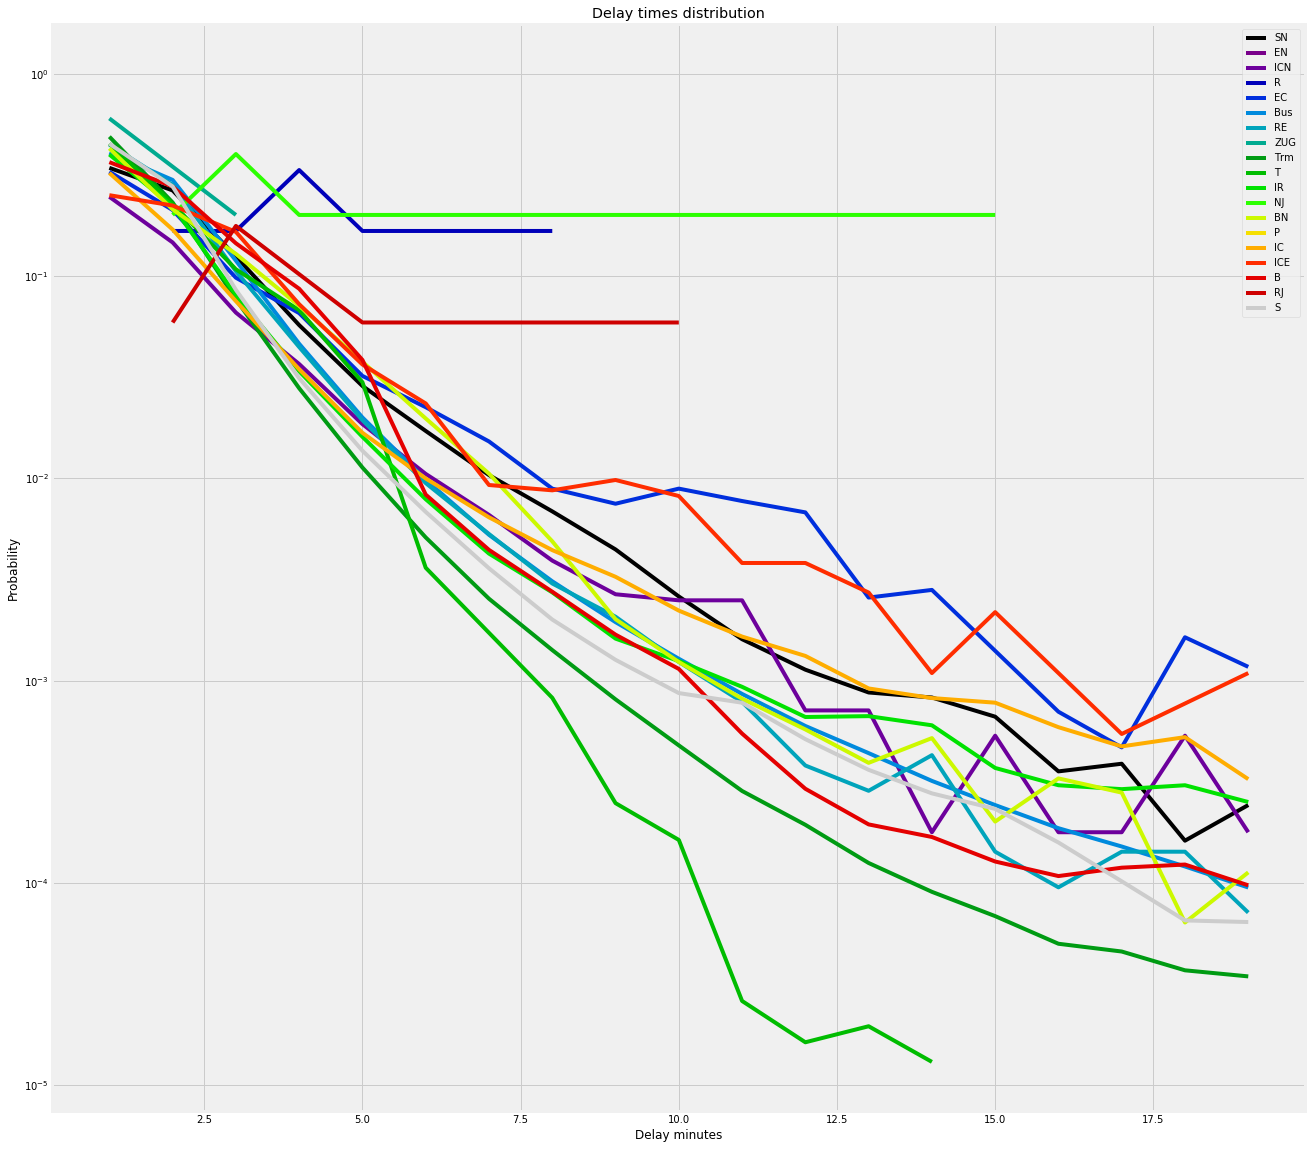

******* name to number mappings *******
0: B
1: BN
2: Bus
3: EC
4: EN
5: IC
6: ICE
7: ICN
8: IR
9: NJ
10: P
11: R
12: RE
13: RJ
14: RJX
15: S
16: SN
17: T
18: TGV
19: Trm
20: ZUG
21: None
******* prediction groups *******
+----------------+----------+
|SERVICE_TYPE_num|prediction|
+----------------+----------+
|               7|         4|
|              15|         4|
|              11|         1|
|               3|         0|
|               8|         4|
|              16|         4|
|               0|         4|
|               5|         4|
|              17|         0|
|               6|         0|
|              19|         4|
|               9|         1|
|               1|         4|
|              20|         3|
|              12|         4|
|              13|         2|
|               2|         4|
+----------------+----------+

{7: 4, 15: 4, 11: 1, 3: 0, 8: 4, 16: 4, 0: 4, 5: 4, 17: 0, 6: 0, 19: 4, 9: 1, 1: 4, 20: 3, 12: 4, 13: 2, 2: 4}


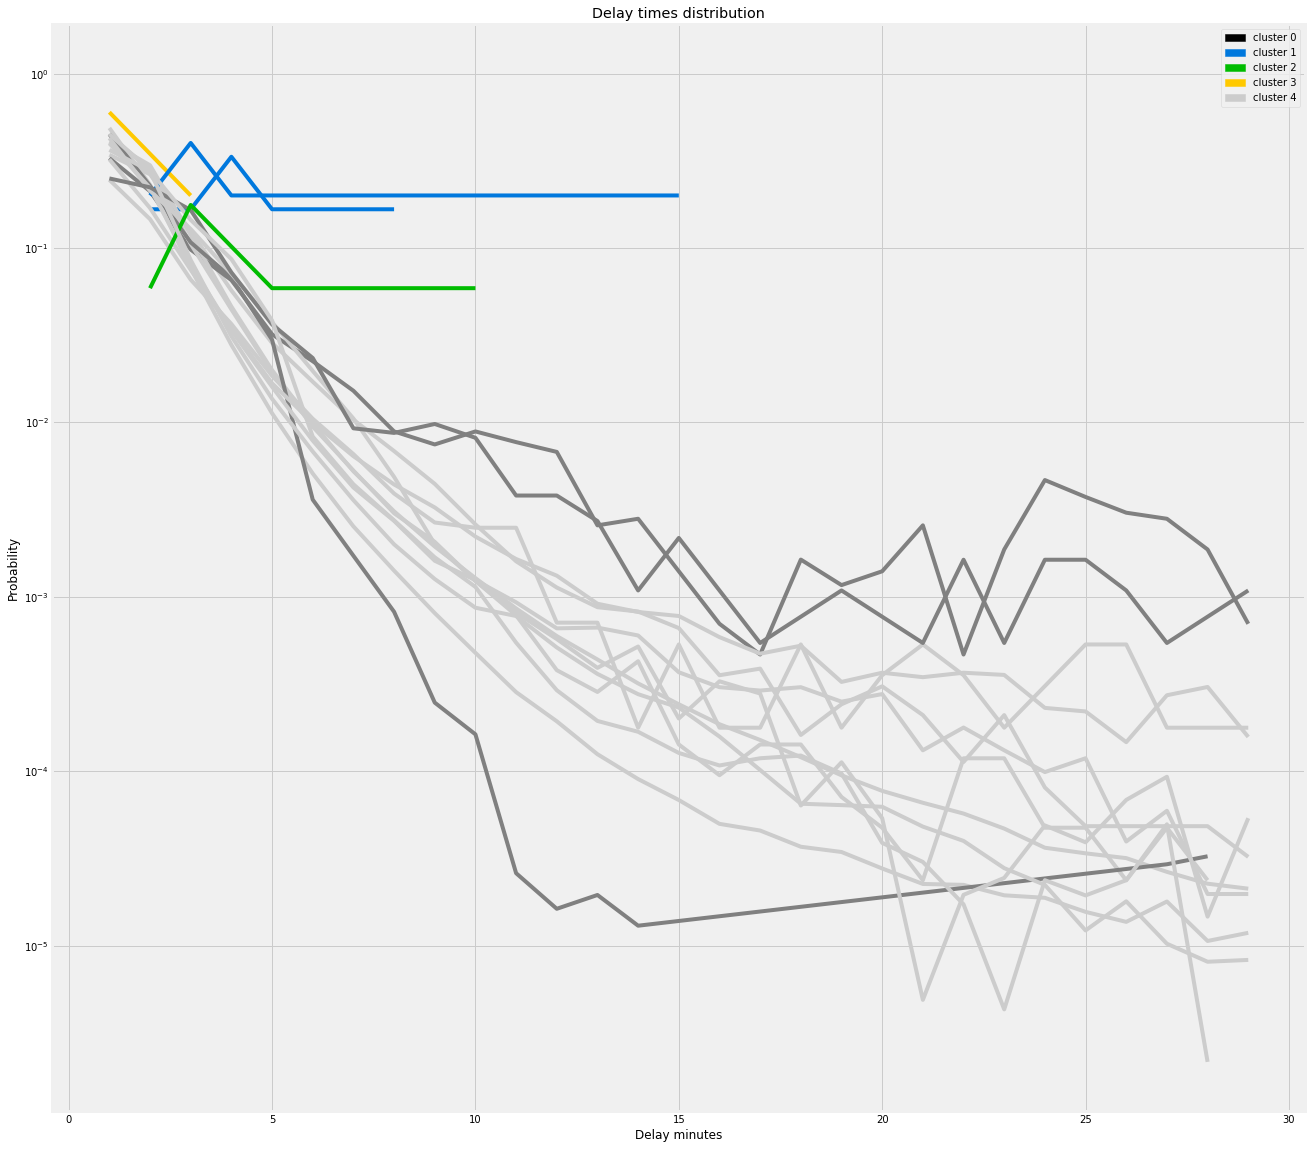

In [282]:
plot_delay_distribution_and_predict(COLUMN_NAME='SERVICE_TYPE', clusters_num=5)

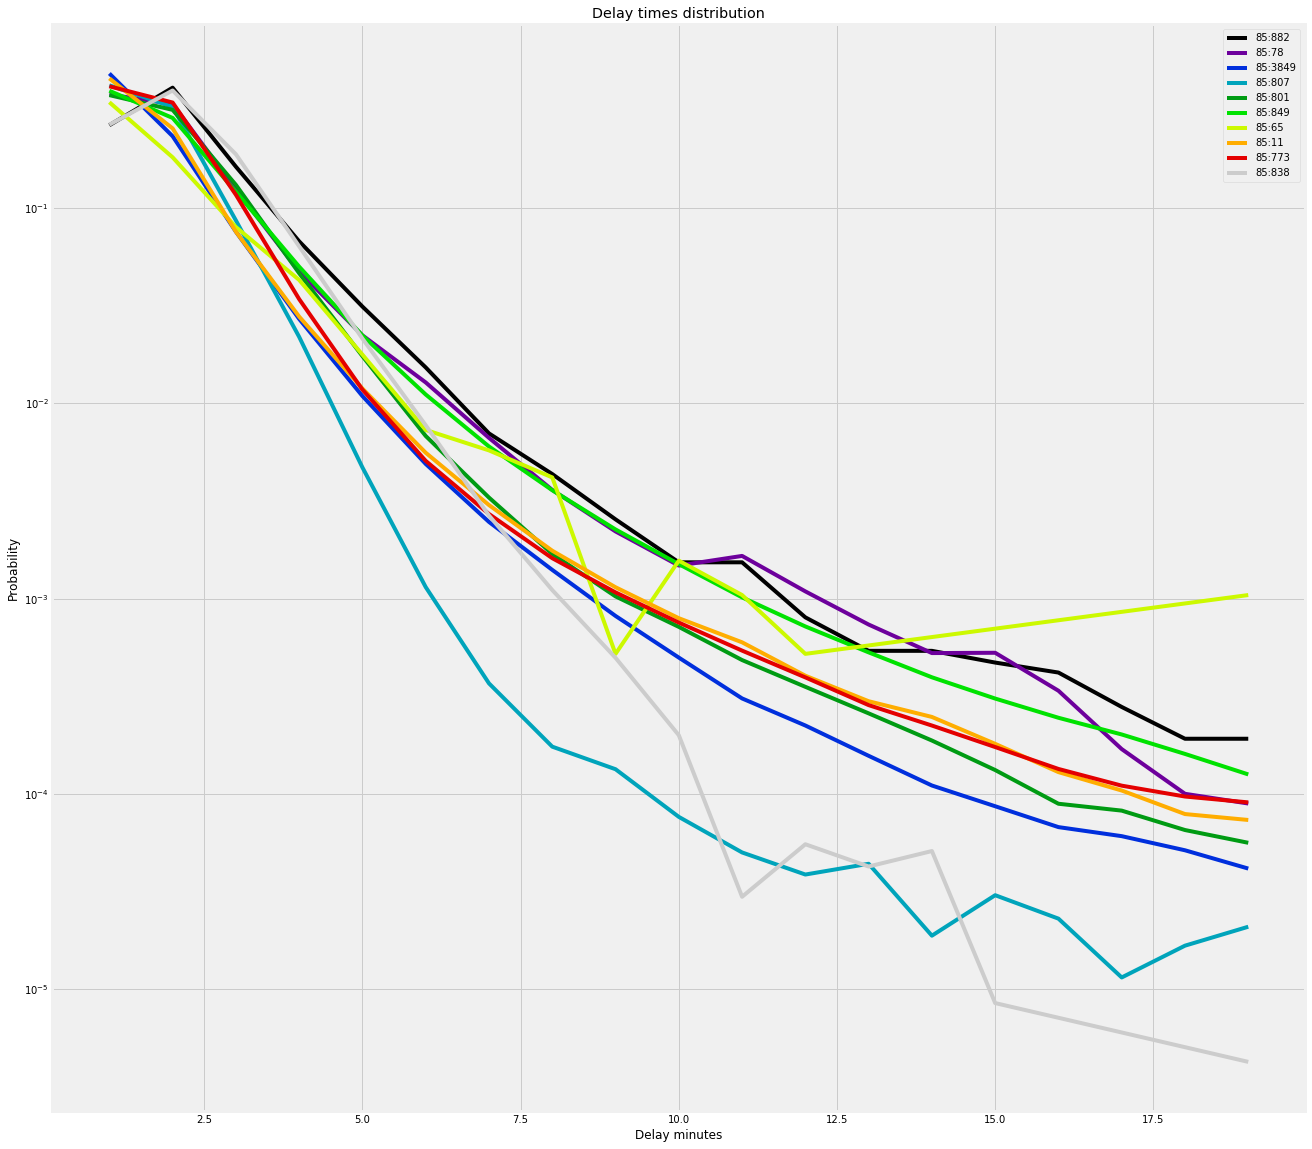

******* name to number mappings *******
0: 85:11
1: 85:3849
2: 85:65
3: 85:773
4: 85:78
5: 85:801
6: 85:807
7: 85:838
8: 85:849
9: 85:882
******* prediction groups *******
+---------------+----------+
|OPERATOR_ID_num|prediction|
+---------------+----------+
|              7|         1|
|              3|         0|
|              8|         3|
|              0|         4|
|              5|         3|
|              6|         4|
|              9|         3|
|              1|         4|
|              4|         3|
|              2|         2|
+---------------+----------+

{7: 1, 3: 0, 8: 3, 0: 4, 5: 3, 6: 4, 9: 3, 1: 4, 4: 3, 2: 2}


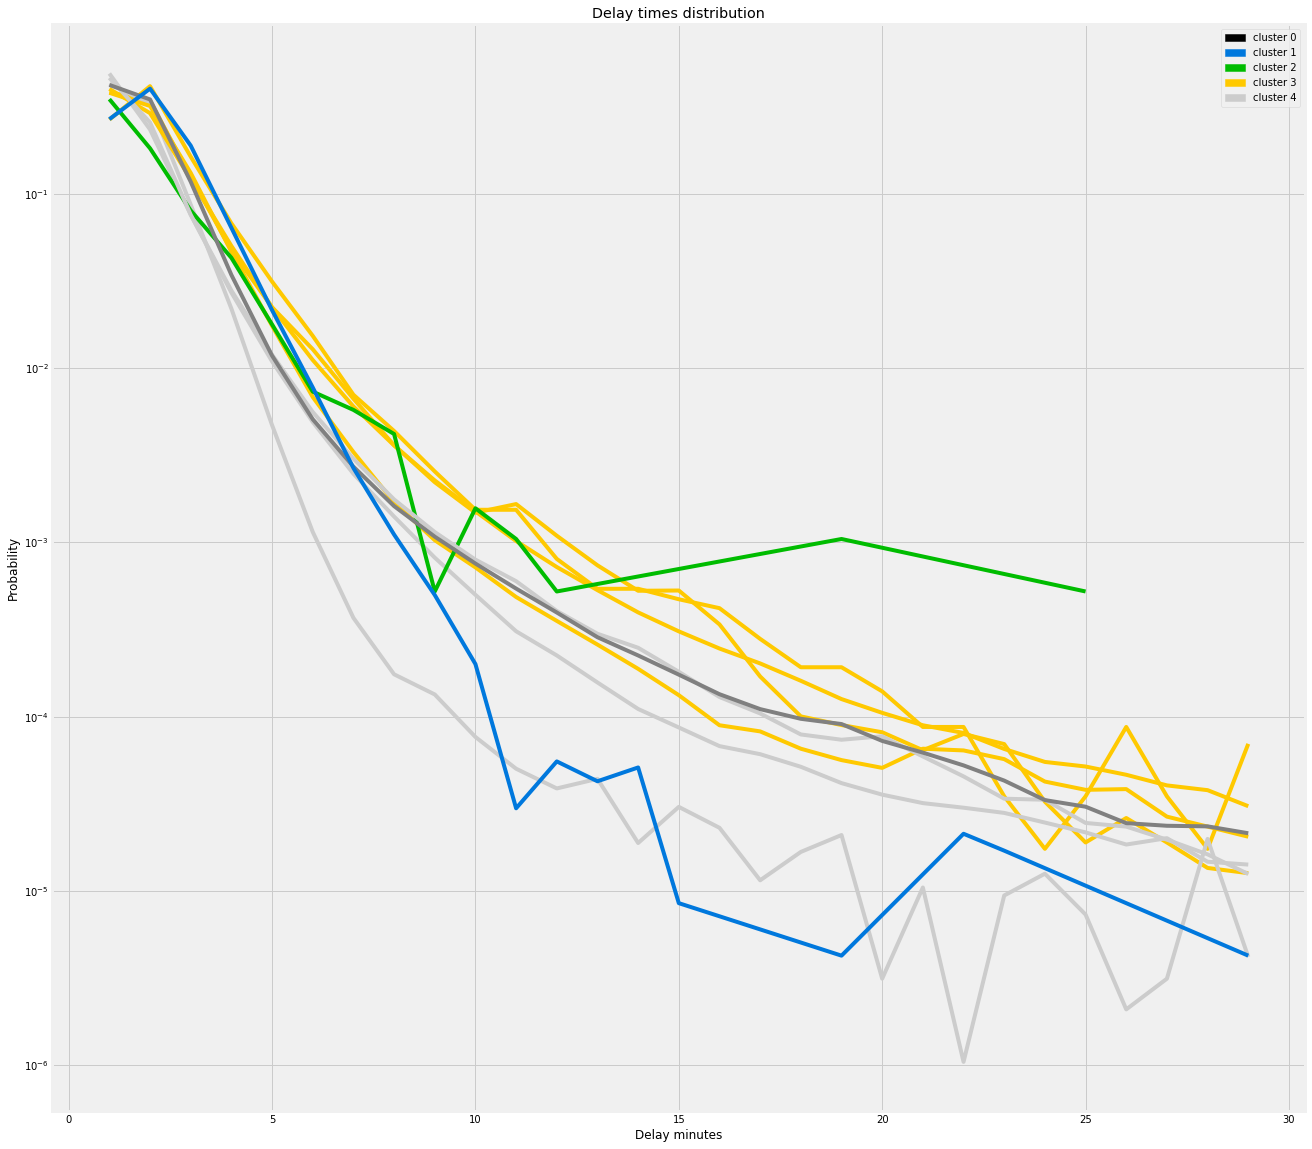

In [283]:
plot_delay_distribution_and_predict(COLUMN_NAME='OPERATOR_ID', clusters_num=5)  # TODO: rerun

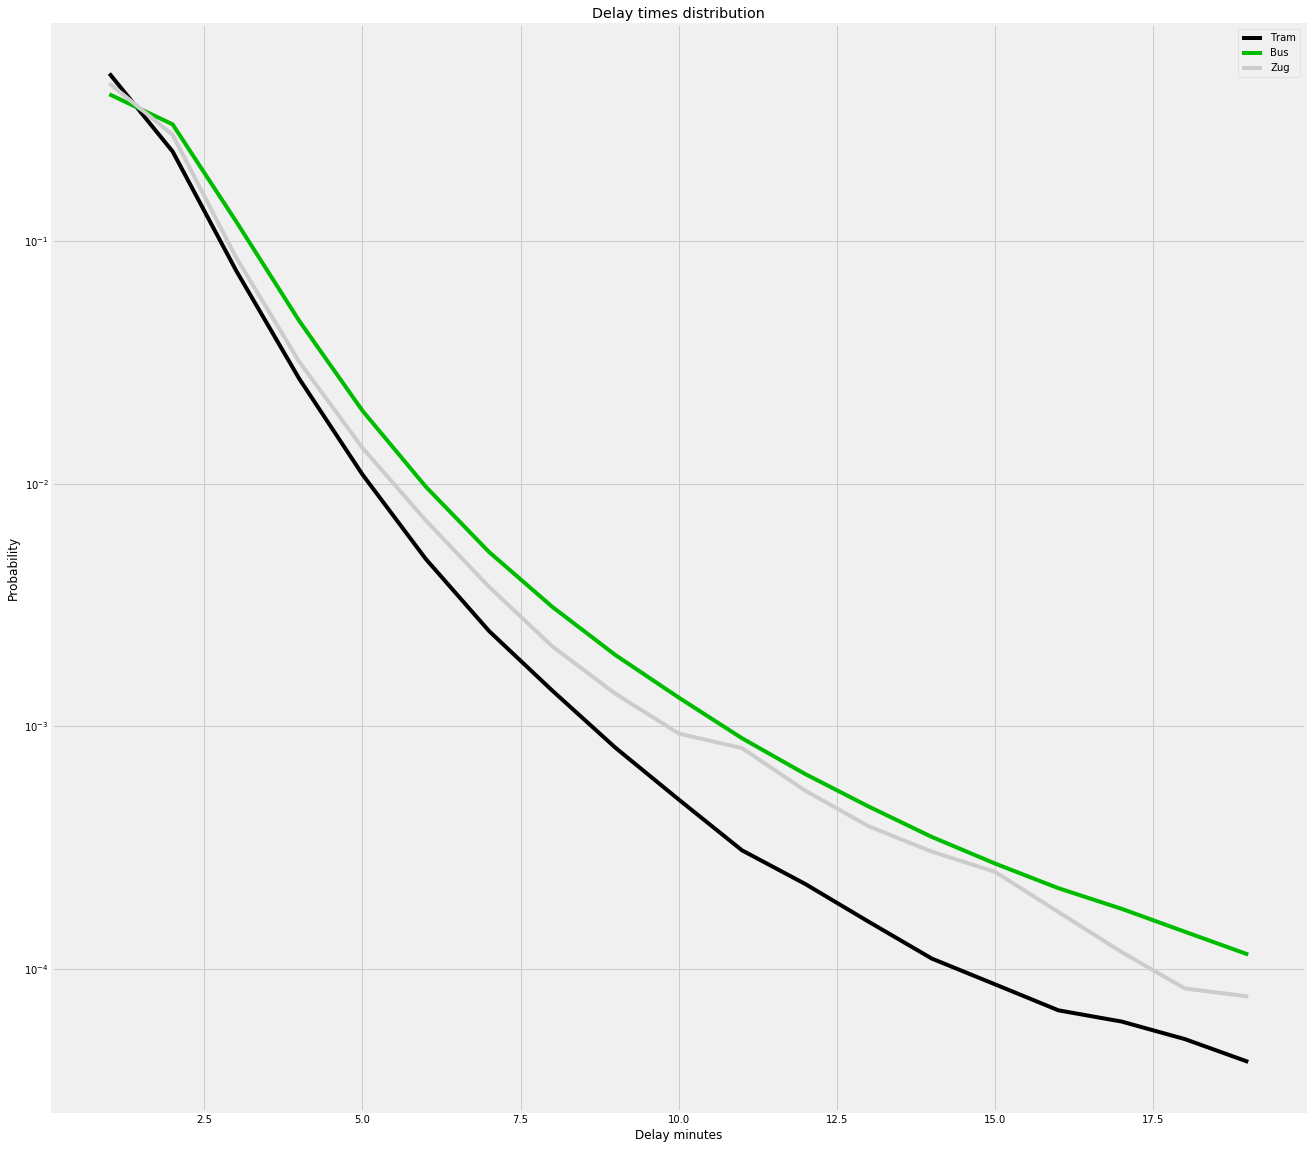

In [284]:
plot_delay_distribution_and_predict(COLUMN_NAME='TRANSPORT_TYPE')

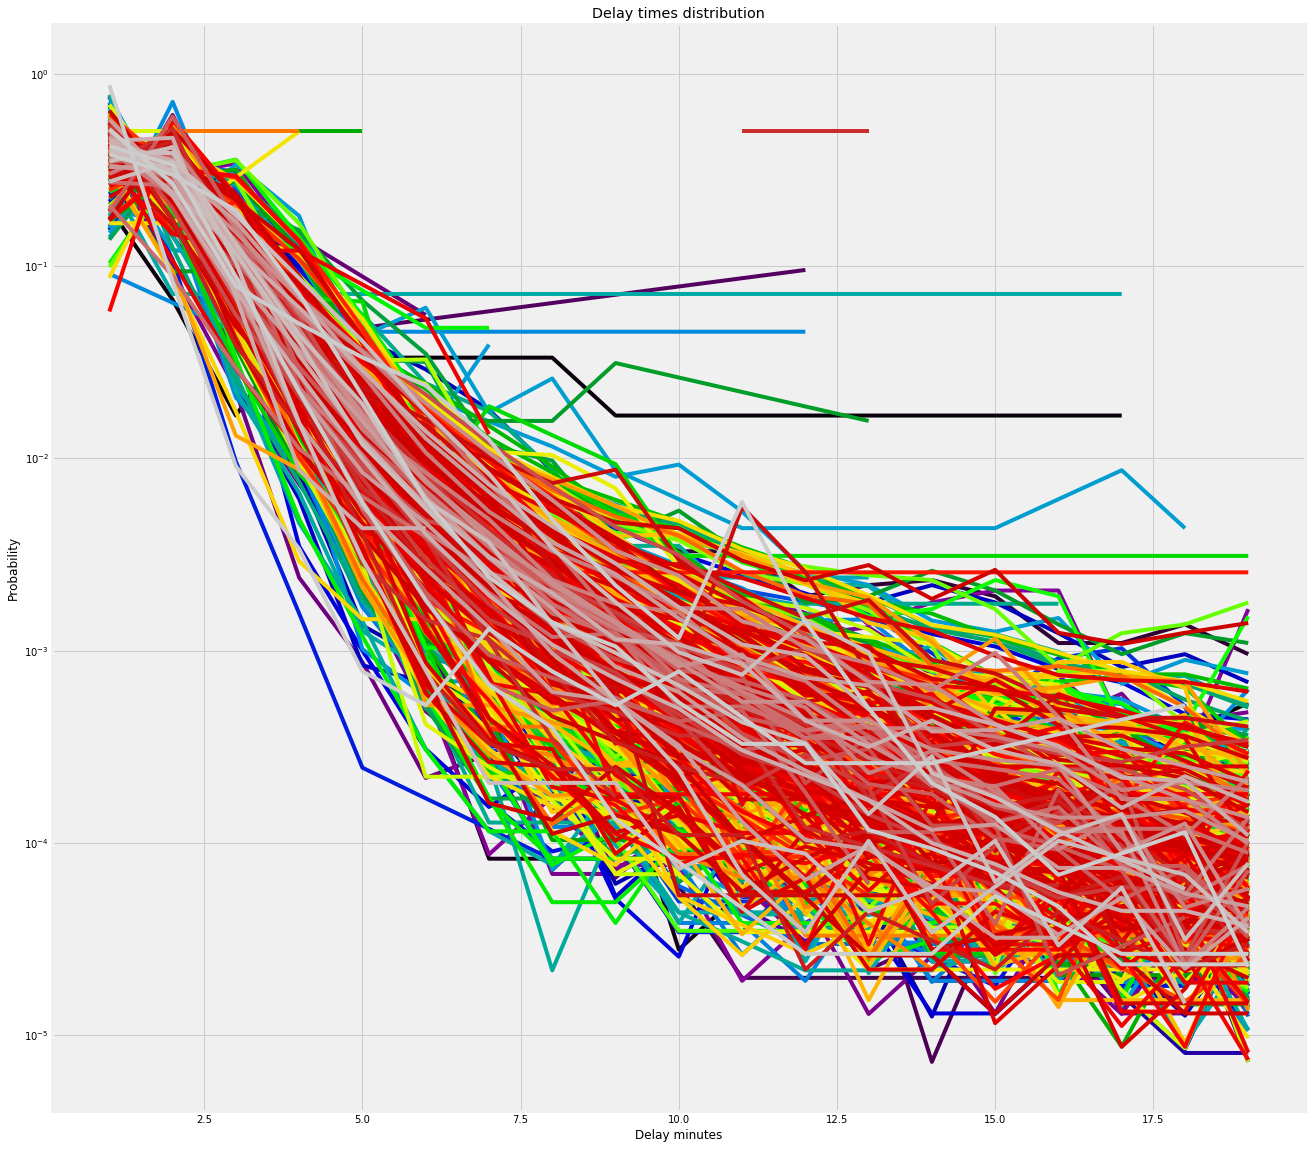

******* name to number mappings *******
0: 8502220
1: 8502221
2: 8502222
3: 8502229
4: 8502559
5: 8502572
6: 8502876
7: 8502885
8: 8502950
9: 8503000
10: 8503001
11: 8503003
12: 8503004
13: 8503006
14: 8503007
15: 8503008
16: 8503009
17: 8503010
18: 8503011
19: 8503015
20: 8503016
21: 8503020
22: 8503051
23: 8503052
24: 8503053
25: 8503054
26: 8503055
27: 8503056
28: 8503059
29: 8503083
30: 8503086
31: 8503087
32: 8503089
33: 8503090
34: 8503091
35: 8503093
36: 8503094
37: 8503095
38: 8503096
39: 8503099
40: 8503100
41: 8503101
42: 8503102
43: 8503127
44: 8503128
45: 8503129
46: 8503141
47: 8503147
48: 8503154
49: 8503200
50: 8503201
51: 8503202
52: 8503306
53: 8503307
54: 8503308
55: 8503309
56: 8503310
57: 8503311
58: 8503340
59: 8503509
60: 8503512
61: 8503526
62: 8503551
63: 8503578
64: 8503579
65: 8503580
66: 8503610
67: 8503690
68: 8503691
69: 8503692
70: 8503693
71: 8503694
72: 8503696
73: 8503698
74: 8503699
75: 8503700
76: 8503709
77: 8530473
78: 8530811
79: 8530812
80: 853081

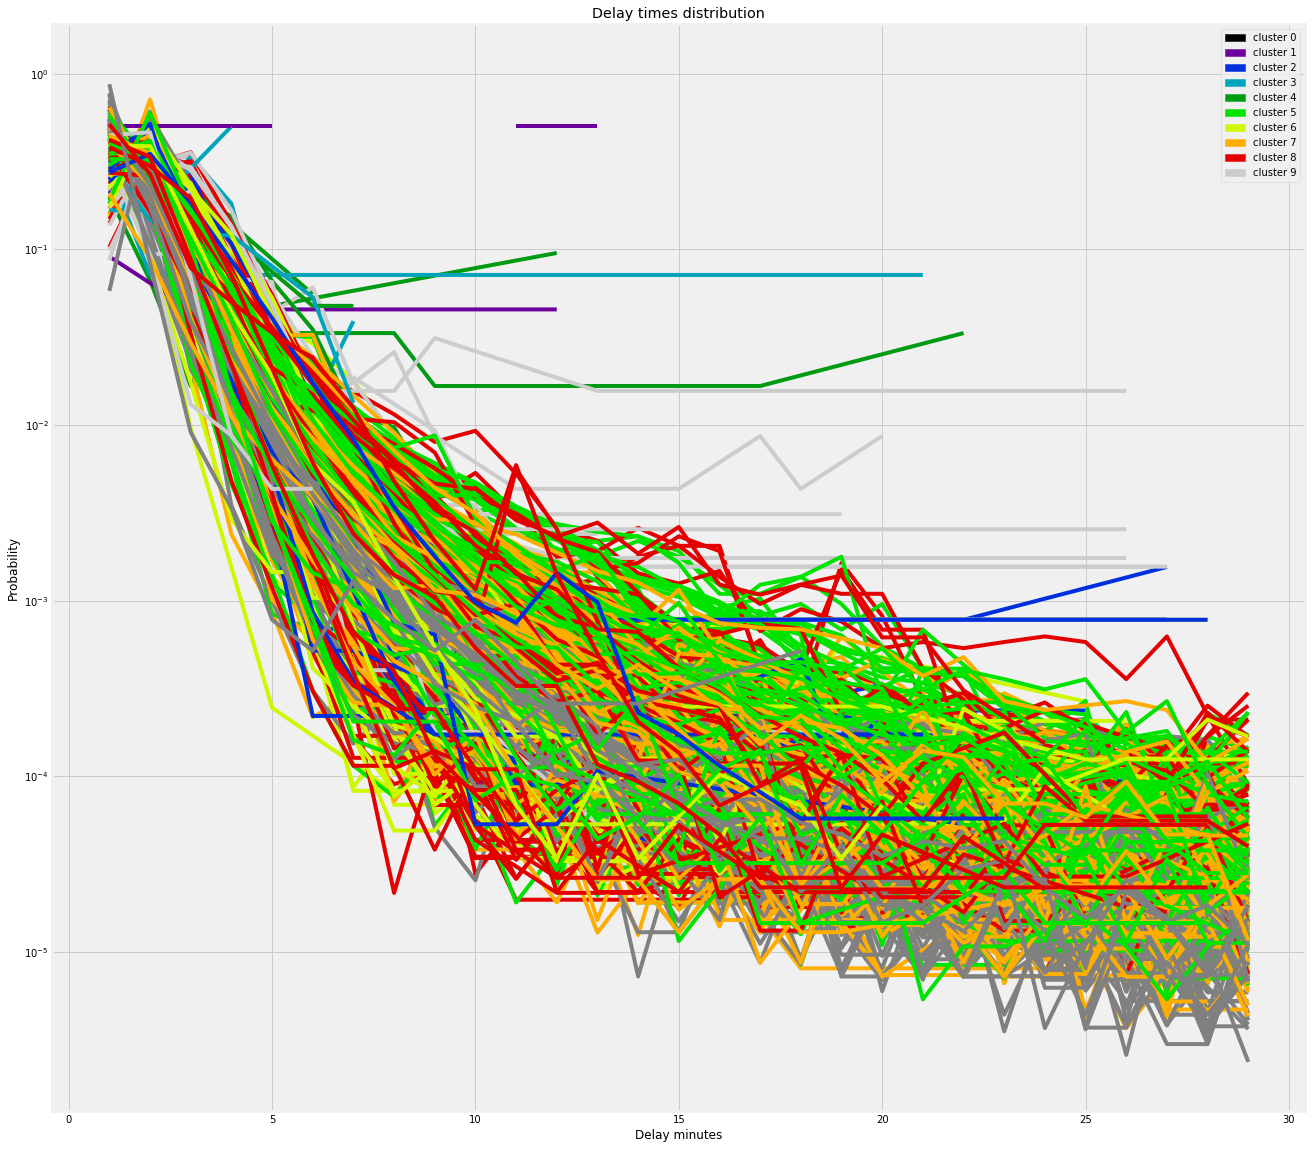

In [285]:
plot_delay_distribution_and_predict(COLUMN_NAME='STATION_ID', clusters_num=10, legend=False)

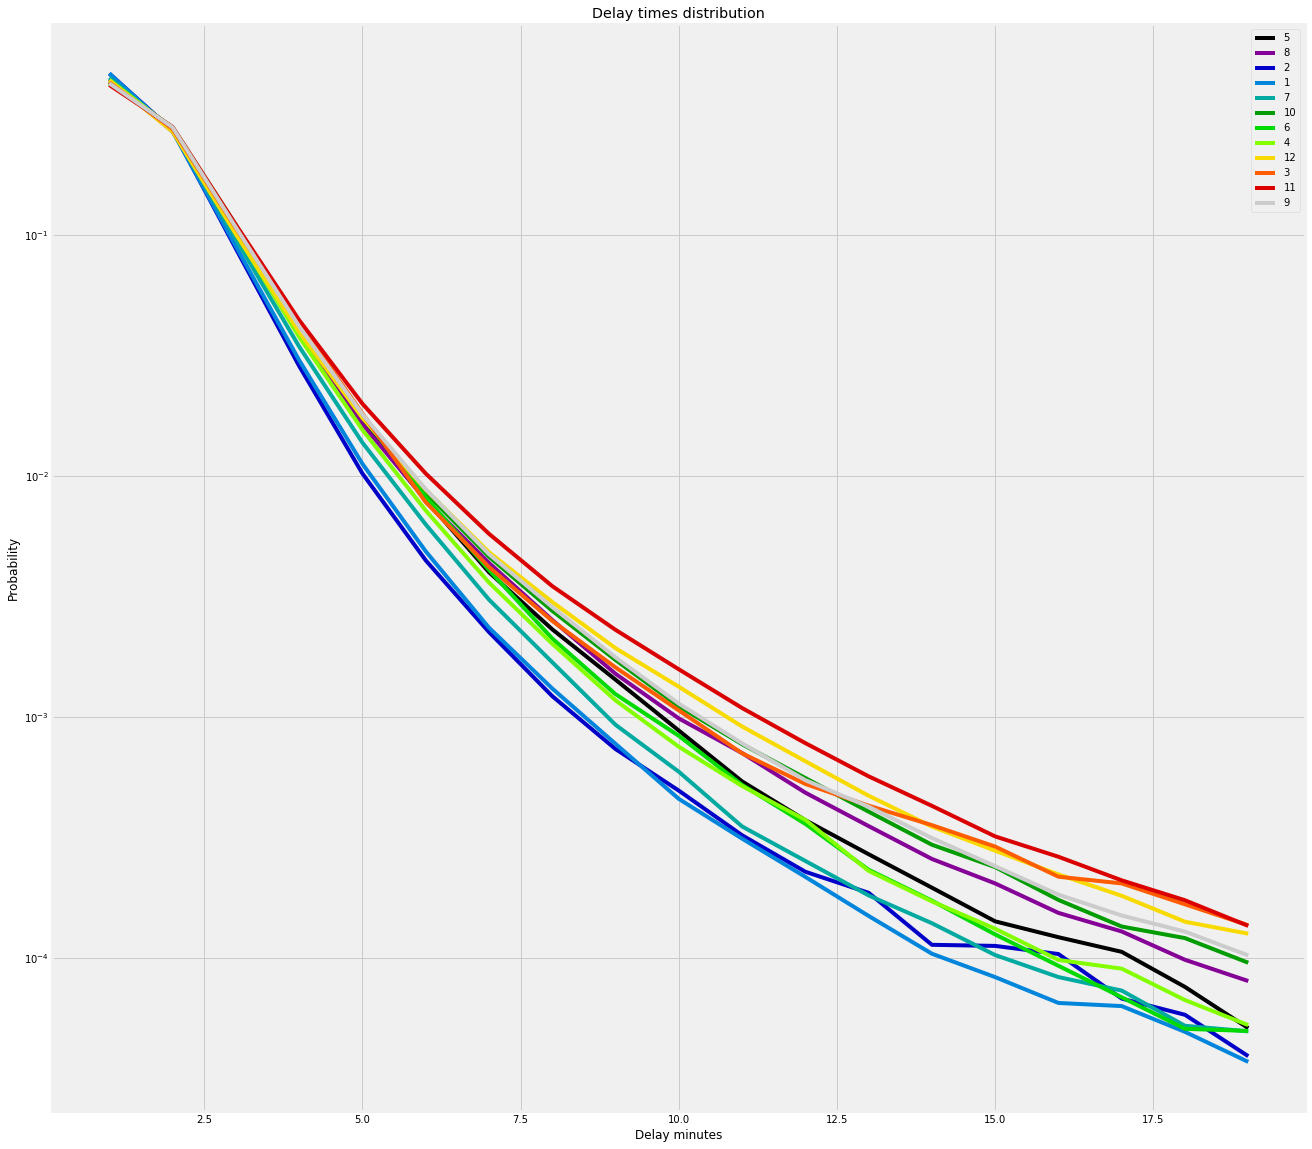

******* name to number mappings *******
0: 1
1: 10
2: 11
3: 12
4: 2
5: 3
6: 4
7: 5
8: 6
9: 7
10: 8
11: 9
******* prediction groups *******
+----------------------------+----------+
|ACTUAL_ARRIVE_TIME_month_num|prediction|
+----------------------------+----------+
|                           7|         2|
|                          11|         0|
|                           3|         2|
|                           8|         0|
|                           0|         1|
|                           5|         0|
|                           6|         2|
|                           9|         2|
|                           1|         0|
|                          10|         2|
|                           4|         1|
|                           2|         0|
+----------------------------+----------+

{7: 2, 11: 0, 3: 2, 8: 0, 0: 1, 5: 0, 6: 2, 9: 2, 1: 0, 10: 2, 4: 1, 2: 0}


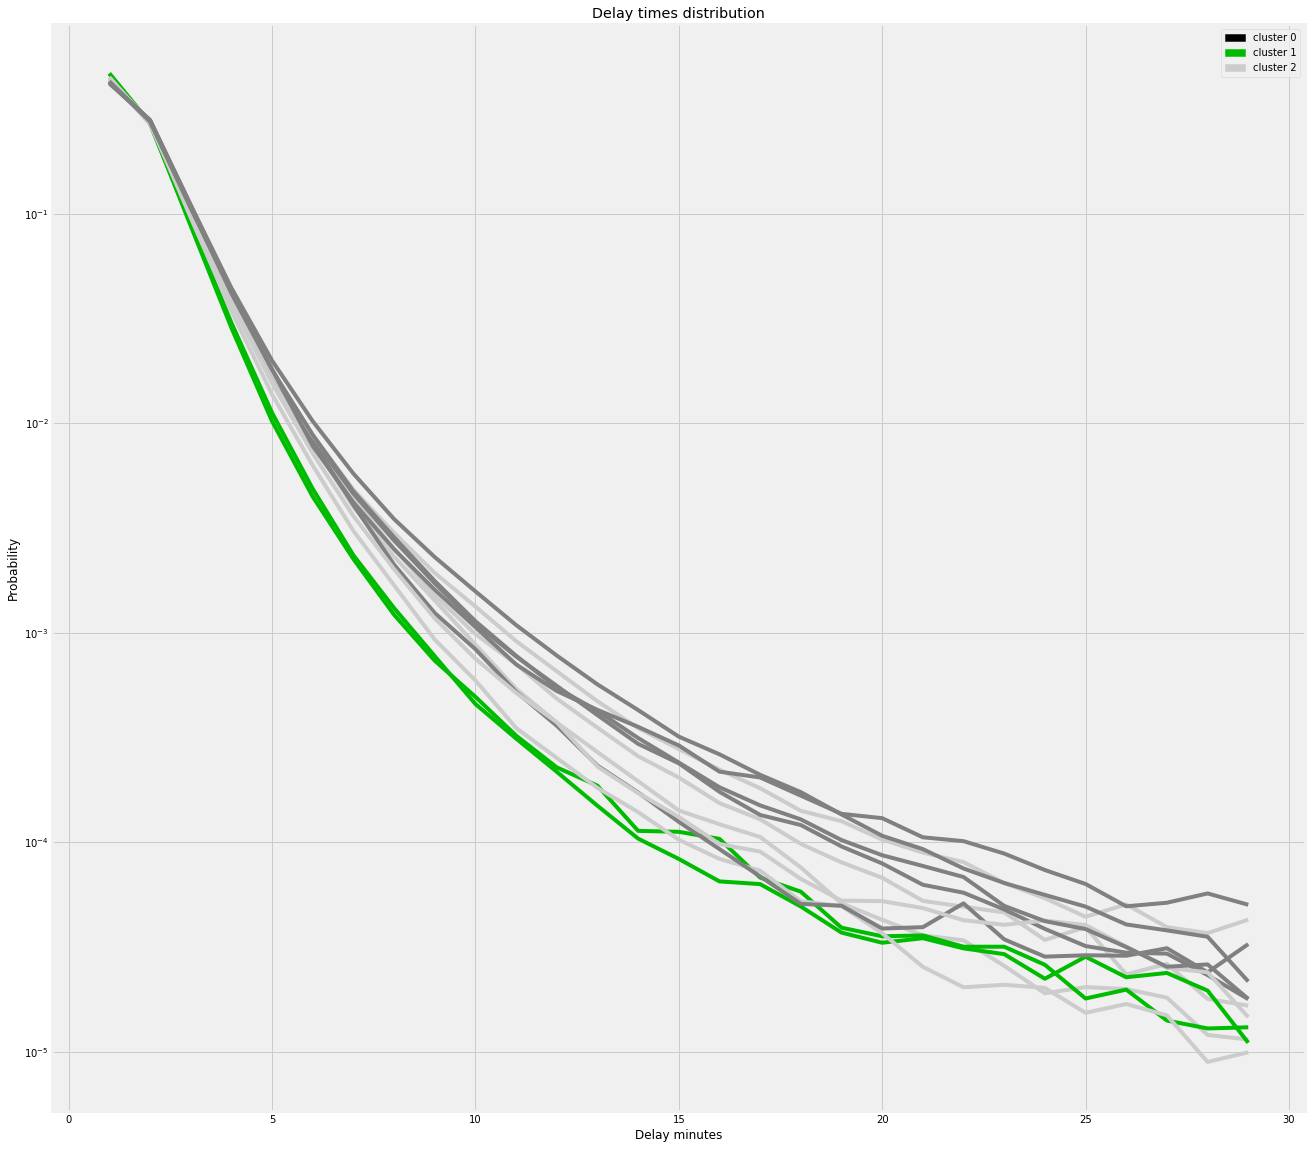

In [286]:
plot_delay_distribution_and_predict(COLUMN_NAME='ACTUAL_ARRIVE_TIME_month', clusters_num=3, legend=True)

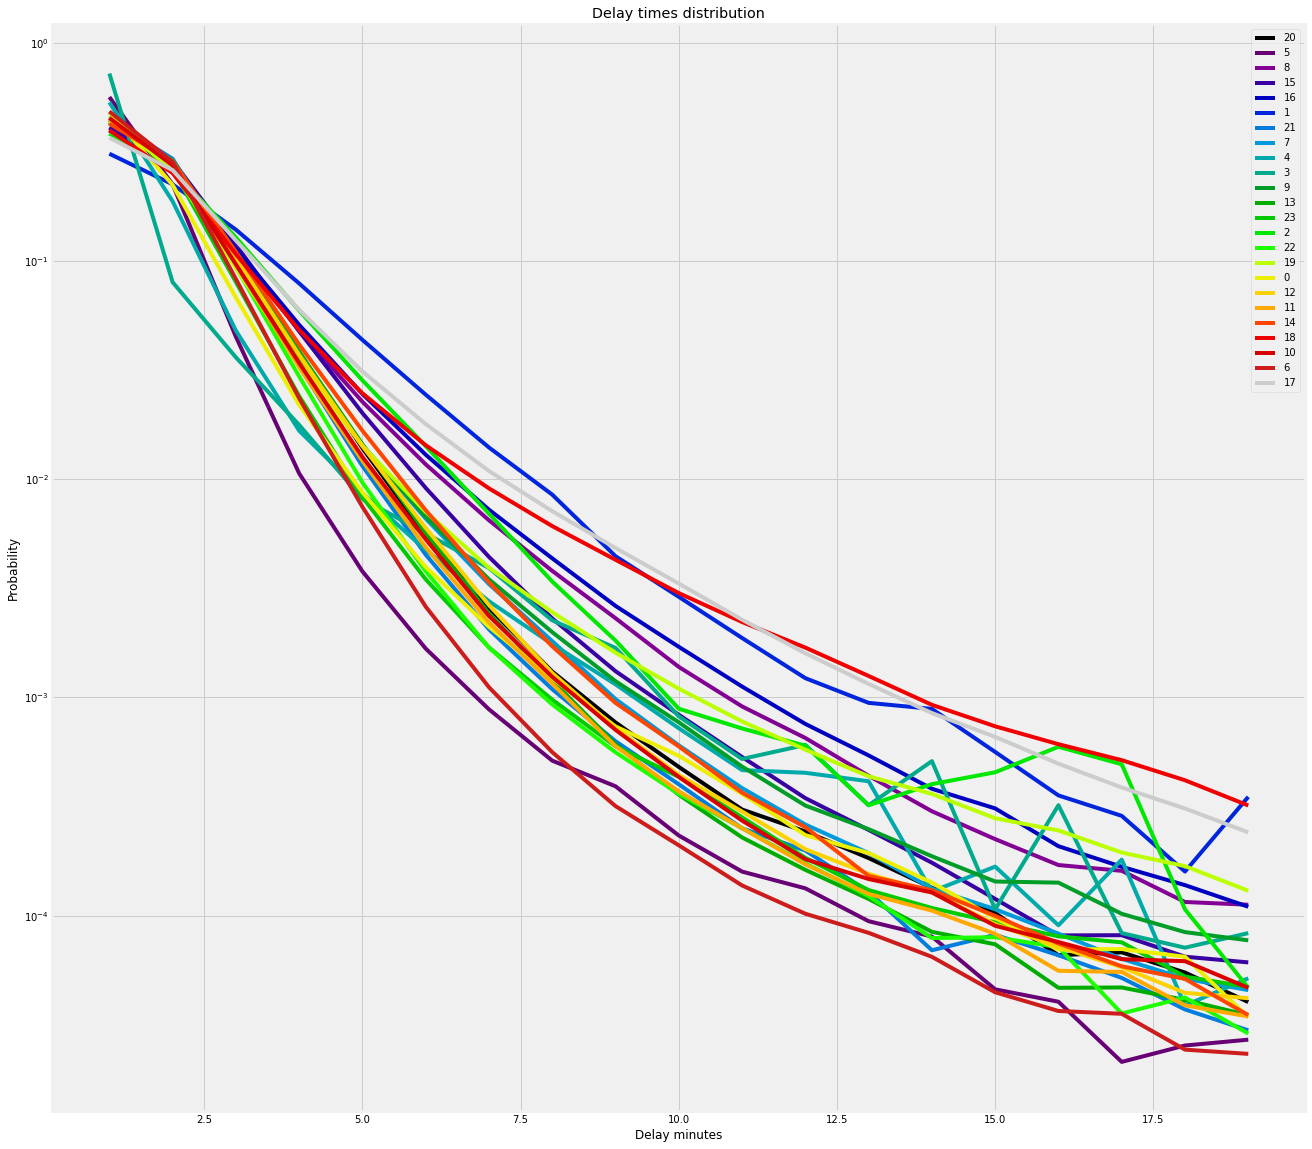

******* name to number mappings *******
0: 0
1: 1
2: 10
3: 11
4: 12
5: 13
6: 14
7: 15
8: 16
9: 17
10: 18
11: 19
12: 2
13: 20
14: 21
15: 22
16: 23
17: 3
18: 4
19: 5
20: 6
21: 7
22: 8
23: 9
******* prediction groups *******
+---------------------------+----------+
|ACTUAL_ARRIVE_TIME_hour_num|prediction|
+---------------------------+----------+
|                          7|         0|
|                         15|         0|
|                         11|         0|
|                          3|         0|
|                          8|         0|
|                         22|         0|
|                         16|         1|
|                          0|         1|
|                          5|         0|
|                         18|         1|
|                         17|         1|
|                          6|         0|
|                         19|         1|
|                         23|         0|
|                          9|         2|
|                          1|         2|

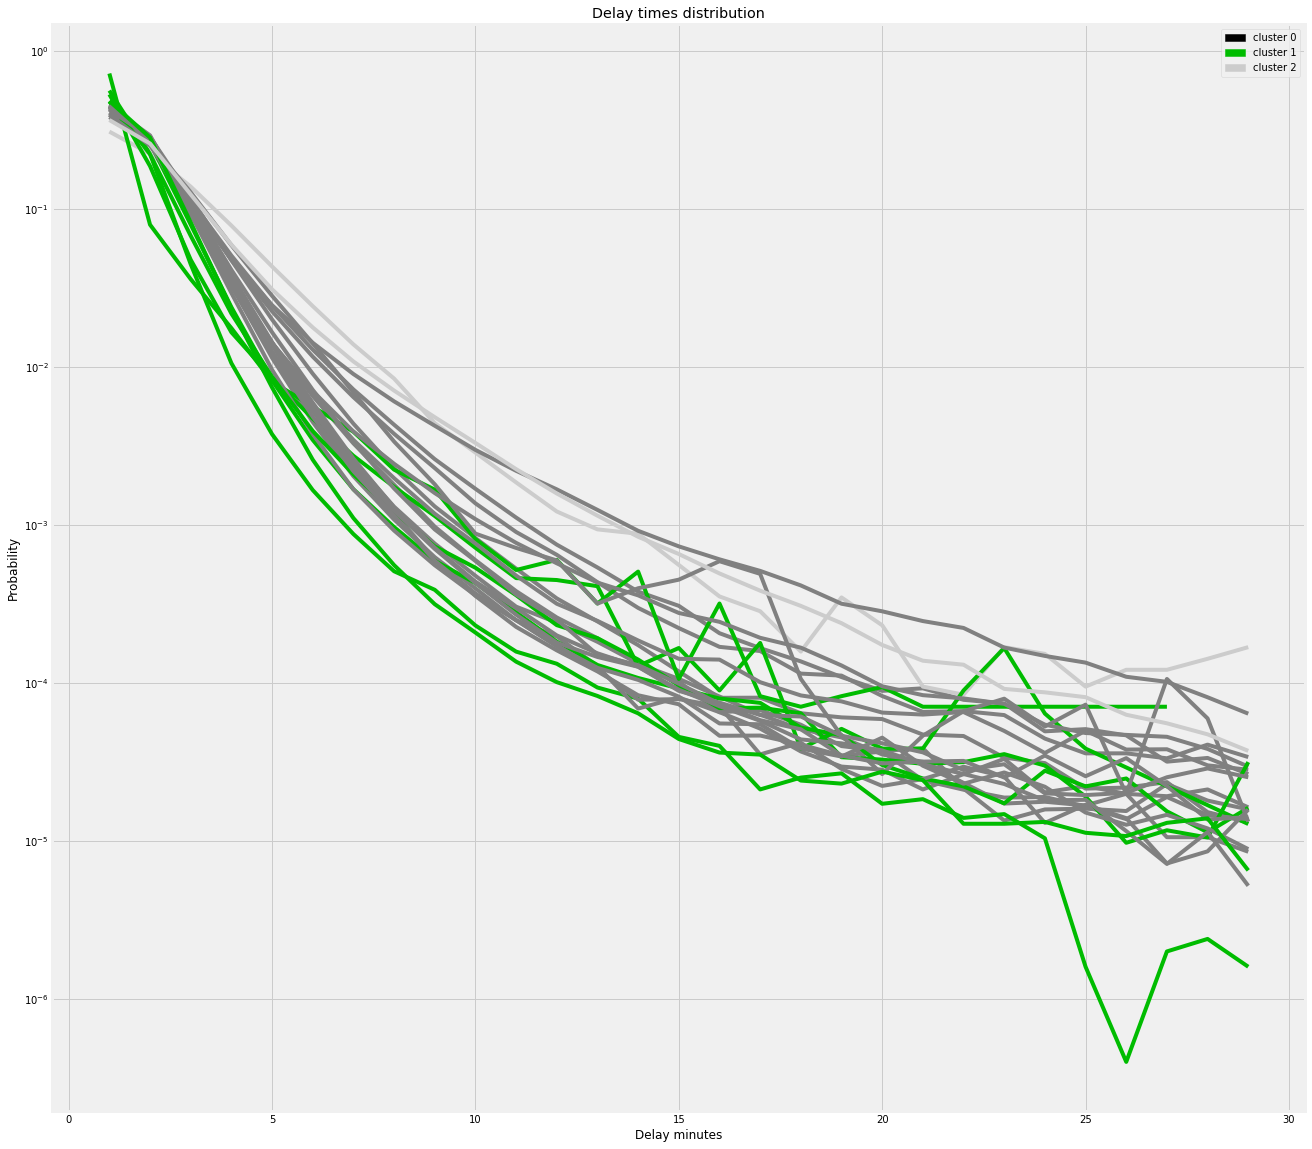

In [287]:
plot_delay_distribution_and_predict(COLUMN_NAME='ACTUAL_ARRIVE_TIME_hour', clusters_num=3, legend=True)

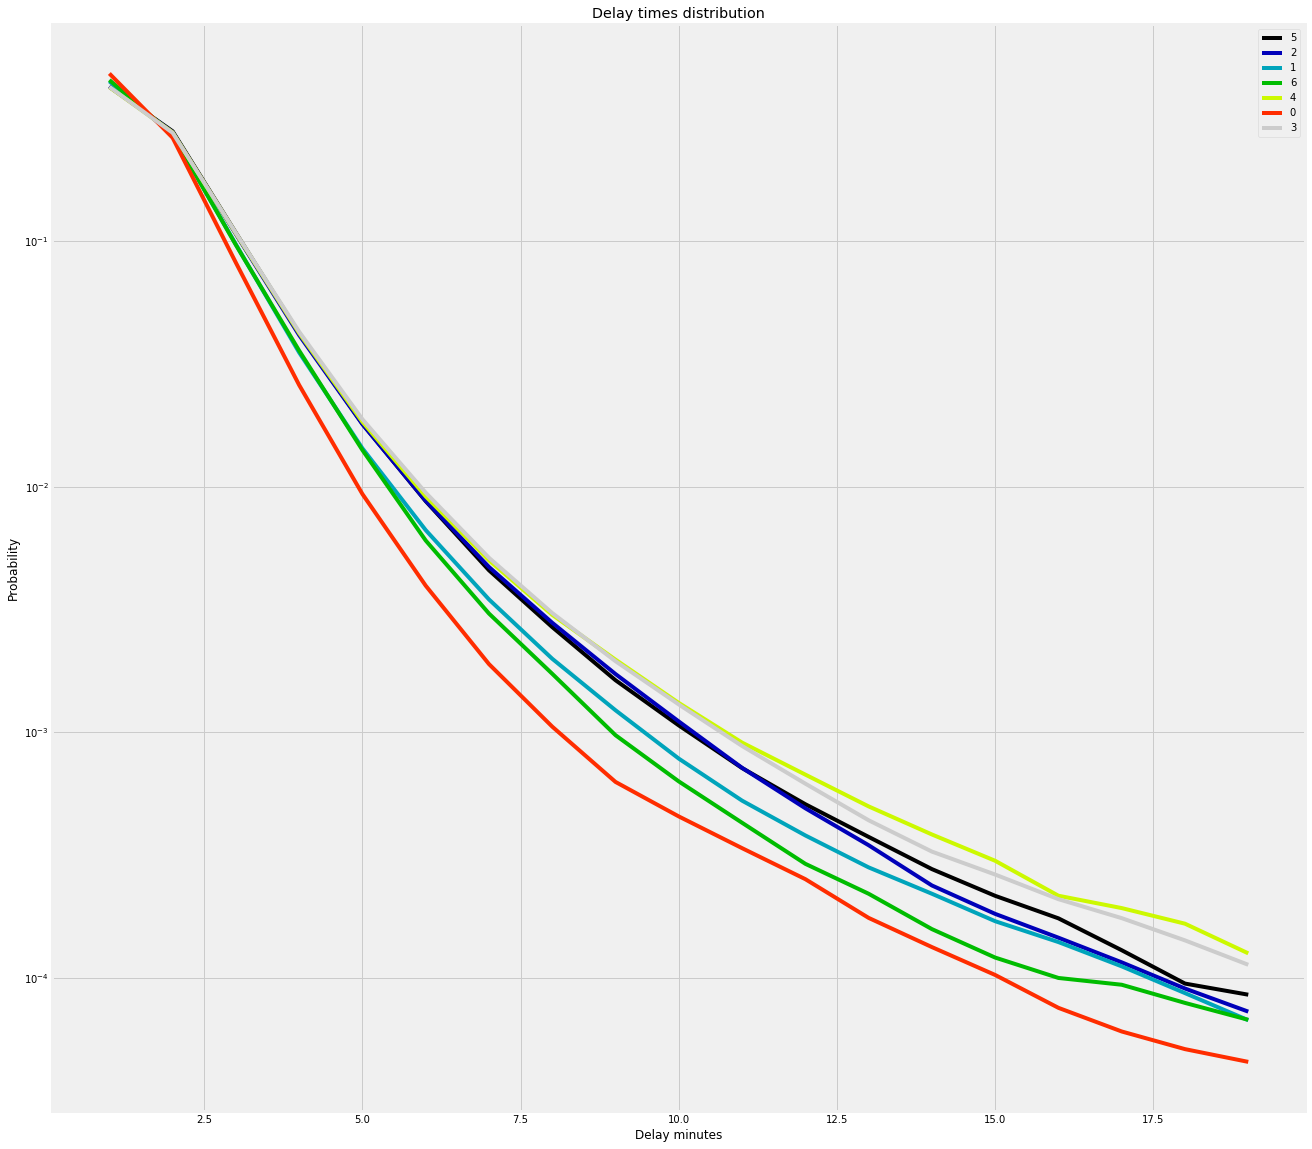

******* name to number mappings *******
0: 0
1: 1
2: 2
3: 3
4: 4
5: 5
6: 6
******* prediction groups *******
+-------------------------------+----------+
|ACTUAL_ARRIVE_TIME_week_day_num|prediction|
+-------------------------------+----------+
|                              3|         0|
|                              0|         1|
|                              5|         0|
|                              6|         2|
|                              1|         2|
|                              4|         0|
|                              2|         0|
+-------------------------------+----------+

{3: 0, 0: 1, 5: 0, 6: 2, 1: 2, 4: 0, 2: 0}


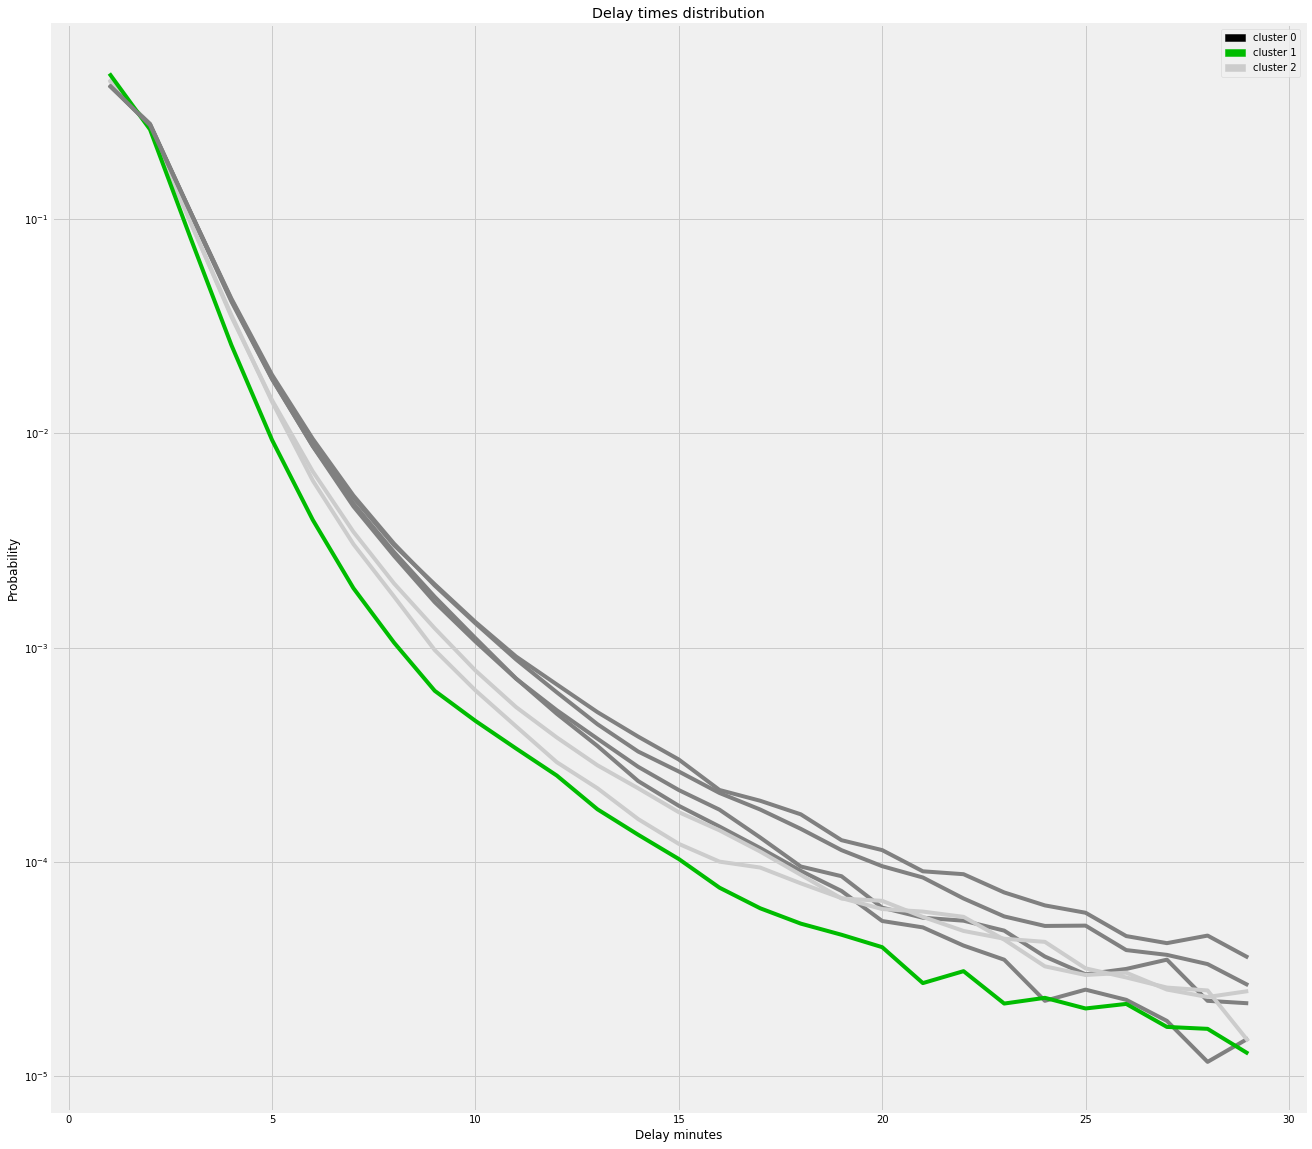

In [290]:
plot_delay_distribution_and_predict(COLUMN_NAME='ACTUAL_ARRIVE_TIME_week_day', clusters_num=3, legend=True)

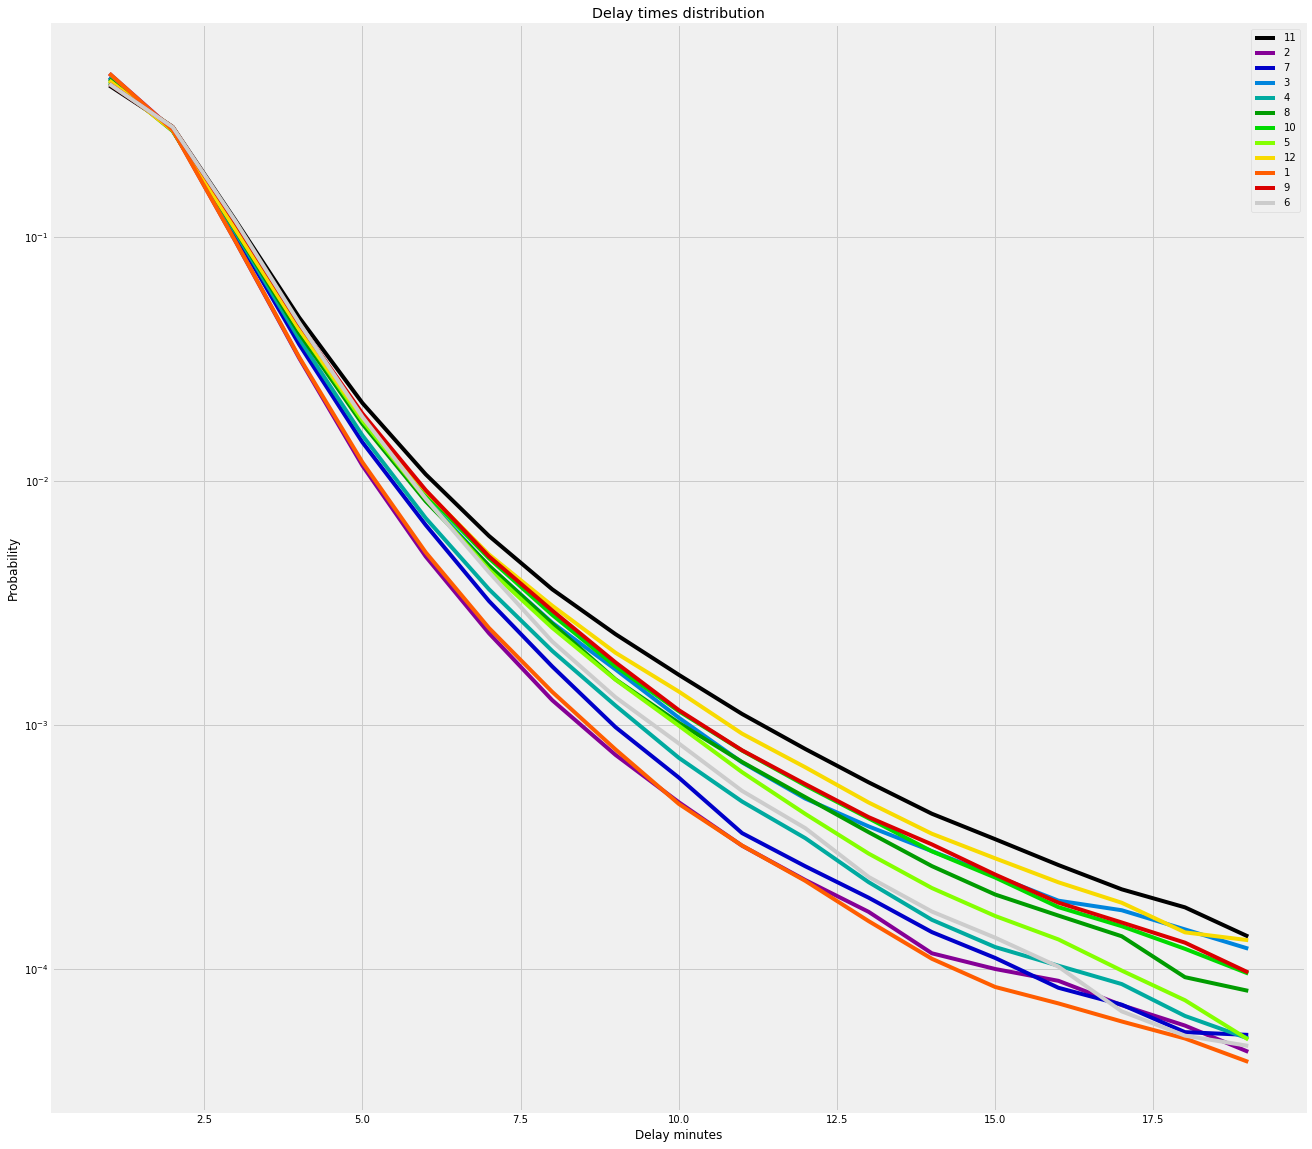

******* name to number mappings *******
0: 1
1: 10
2: 11
3: 12
4: 2
5: 3
6: 4
7: 5
8: 6
9: 7
10: 8
11: 9
******* prediction groups *******
+----------------------------+----------+
|ACTUAL_DEPART_TIME_month_num|prediction|
+----------------------------+----------+
|                           7|         0|
|                          11|         1|
|                           3|         0|
|                           8|         1|
|                           0|         2|
|                           5|         0|
|                           6|         0|
|                           9|         2|
|                           1|         1|
|                          10|         0|
|                           4|         2|
|                           2|         1|
+----------------------------+----------+

{7: 0, 11: 1, 3: 0, 8: 1, 0: 2, 5: 0, 6: 0, 9: 2, 1: 1, 10: 0, 4: 2, 2: 1}


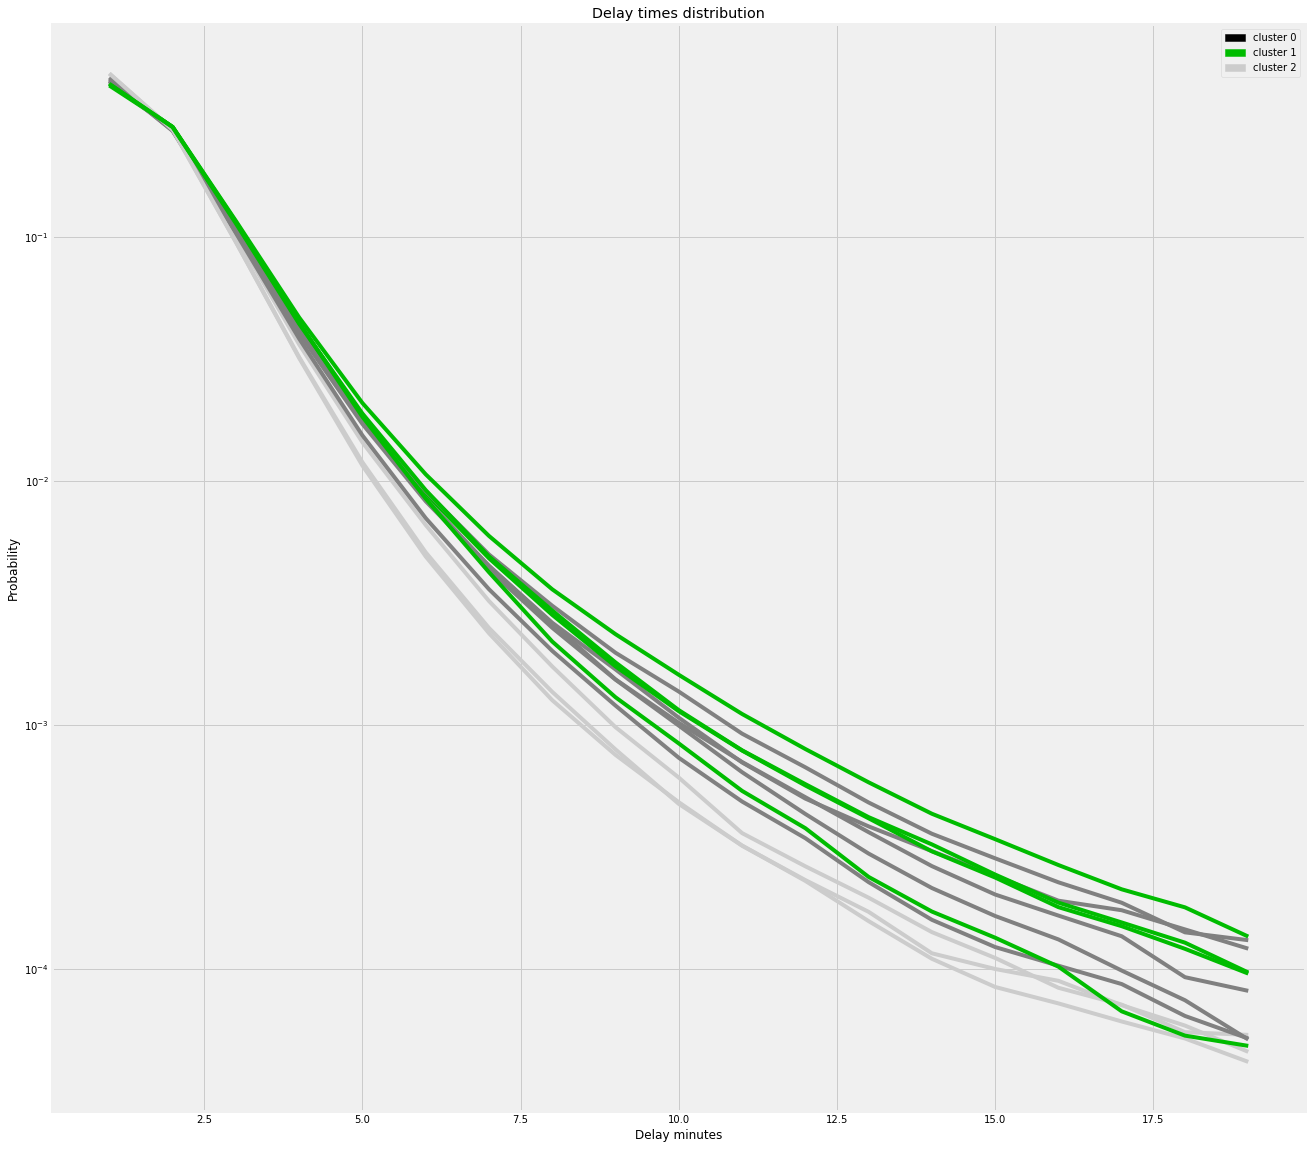

In [38]:
plot_delay_distribution_and_predict_depart(COLUMN_NAME='ACTUAL_DEPART_TIME_month', clusters_num=3, legend=True)

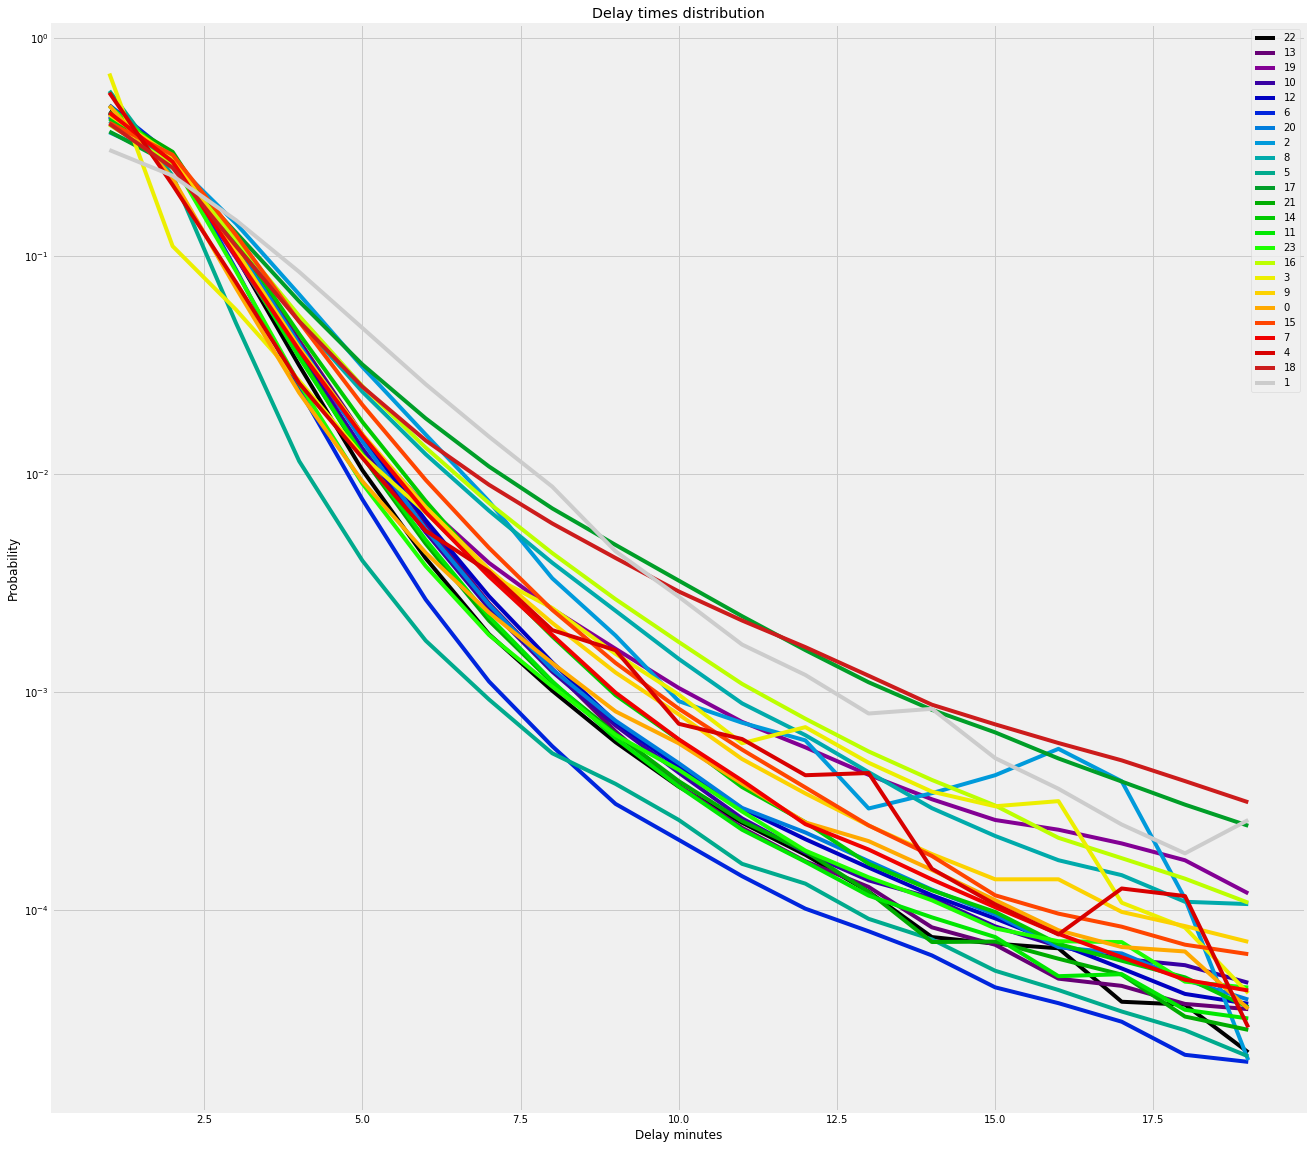

******* name to number mappings *******
0: 0
1: 1
2: 10
3: 11
4: 12
5: 13
6: 14
7: 15
8: 16
9: 17
10: 18
11: 19
12: 2
13: 20
14: 21
15: 22
16: 23
17: 3
18: 4
19: 5
20: 6
21: 7
22: 8
23: 9
******* prediction groups *******
+---------------------------+----------+
|ACTUAL_DEPART_TIME_hour_num|prediction|
+---------------------------+----------+
|                          7|         0|
|                         15|         2|
|                         11|         2|
|                          3|         2|
|                          8|         0|
|                         22|         0|
|                         16|         2|
|                          0|         2|
|                          5|         2|
|                         18|         1|
|                         17|         1|
|                          6|         2|
|                         19|         1|
|                         23|         2|
|                          9|         0|
|                          1|         0|

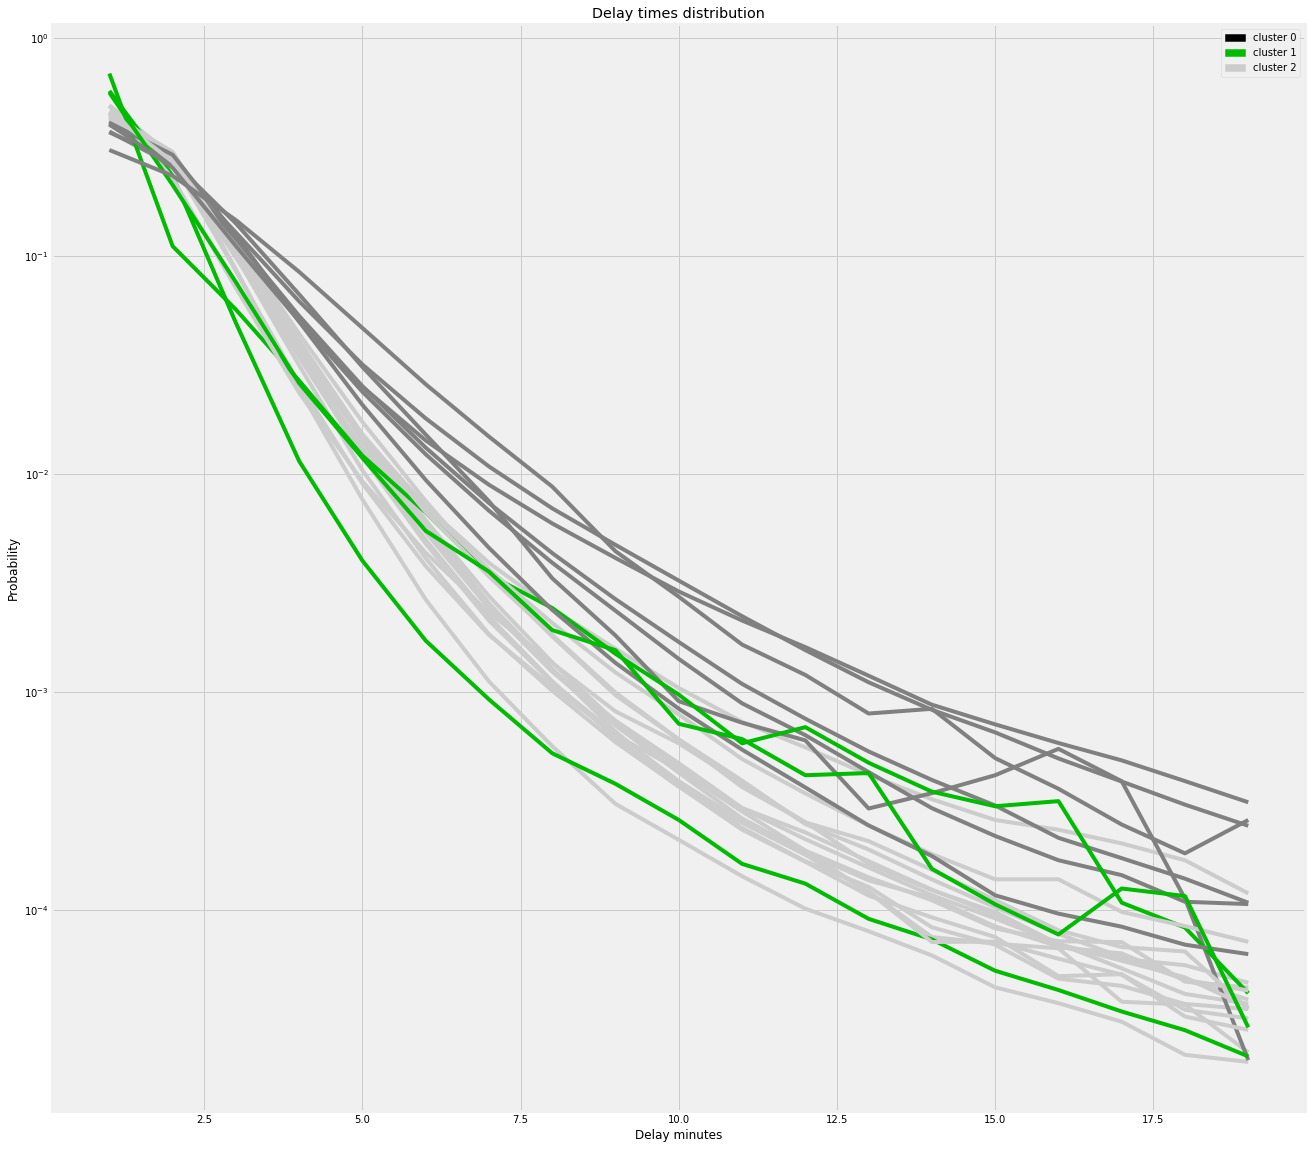

In [39]:
plot_delay_distribution_and_predict_depart(COLUMN_NAME='ACTUAL_DEPART_TIME_hour', clusters_num=3, legend=True)

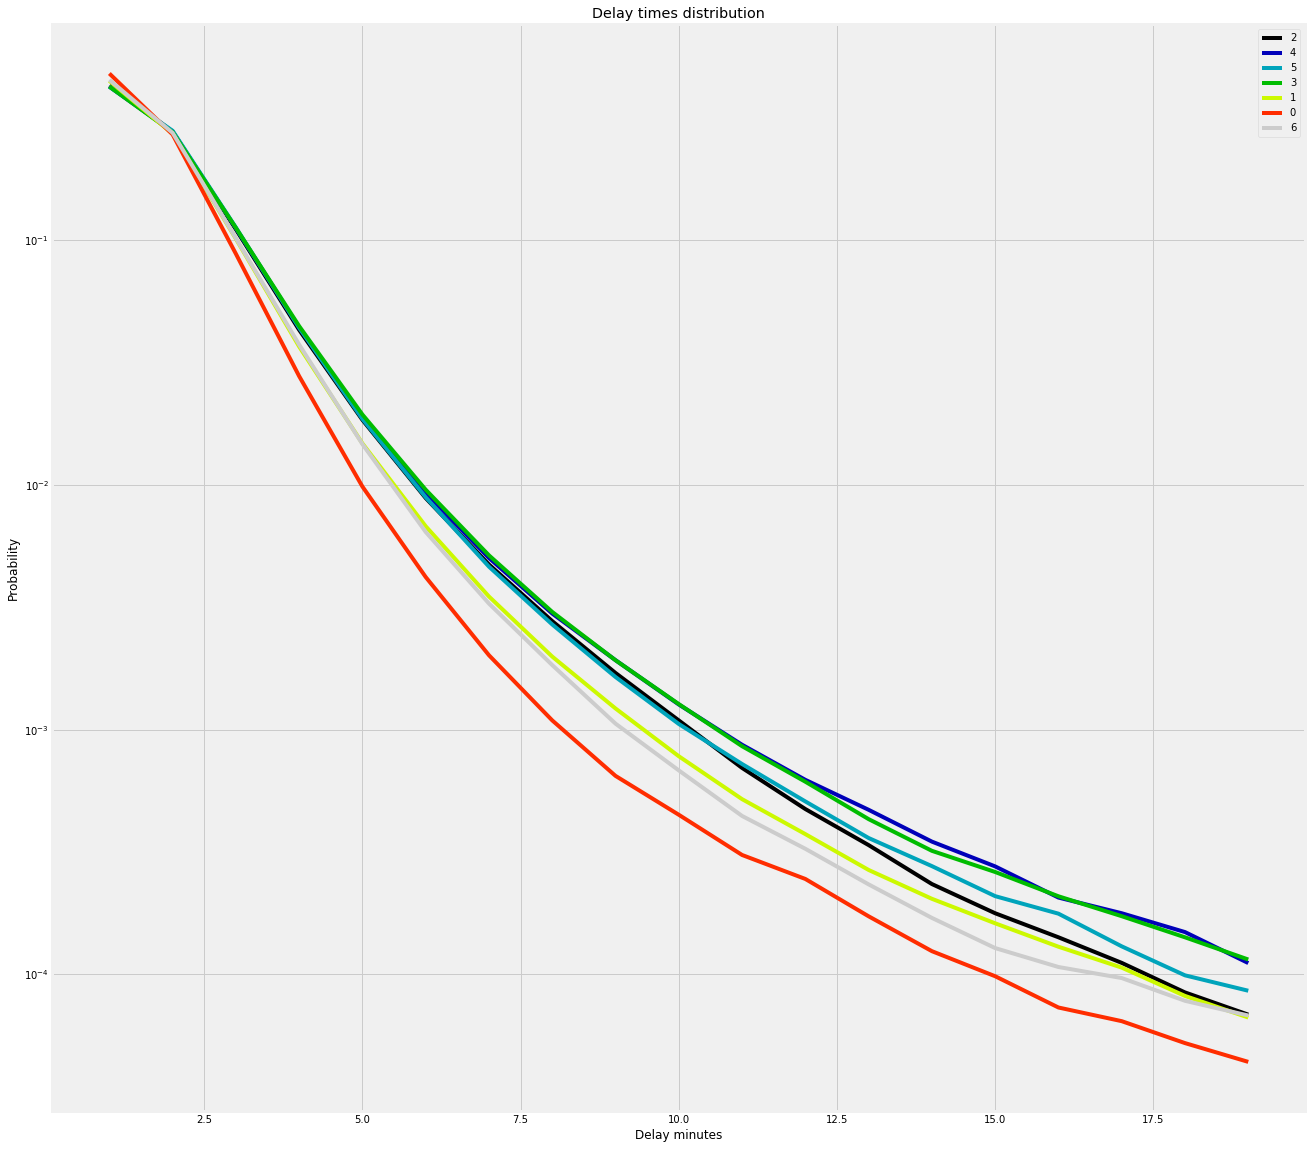

******* name to number mappings *******
0: 0
1: 1
2: 2
3: 3
4: 4
5: 5
6: 6
******* prediction groups *******
+-------------------------------+----------+
|ACTUAL_DEPART_TIME_week_day_num|prediction|
+-------------------------------+----------+
|                              3|         0|
|                              0|         1|
|                              5|         0|
|                              6|         2|
|                              1|         2|
|                              4|         0|
|                              2|         0|
+-------------------------------+----------+

{3: 0, 0: 1, 5: 0, 6: 2, 1: 2, 4: 0, 2: 0}


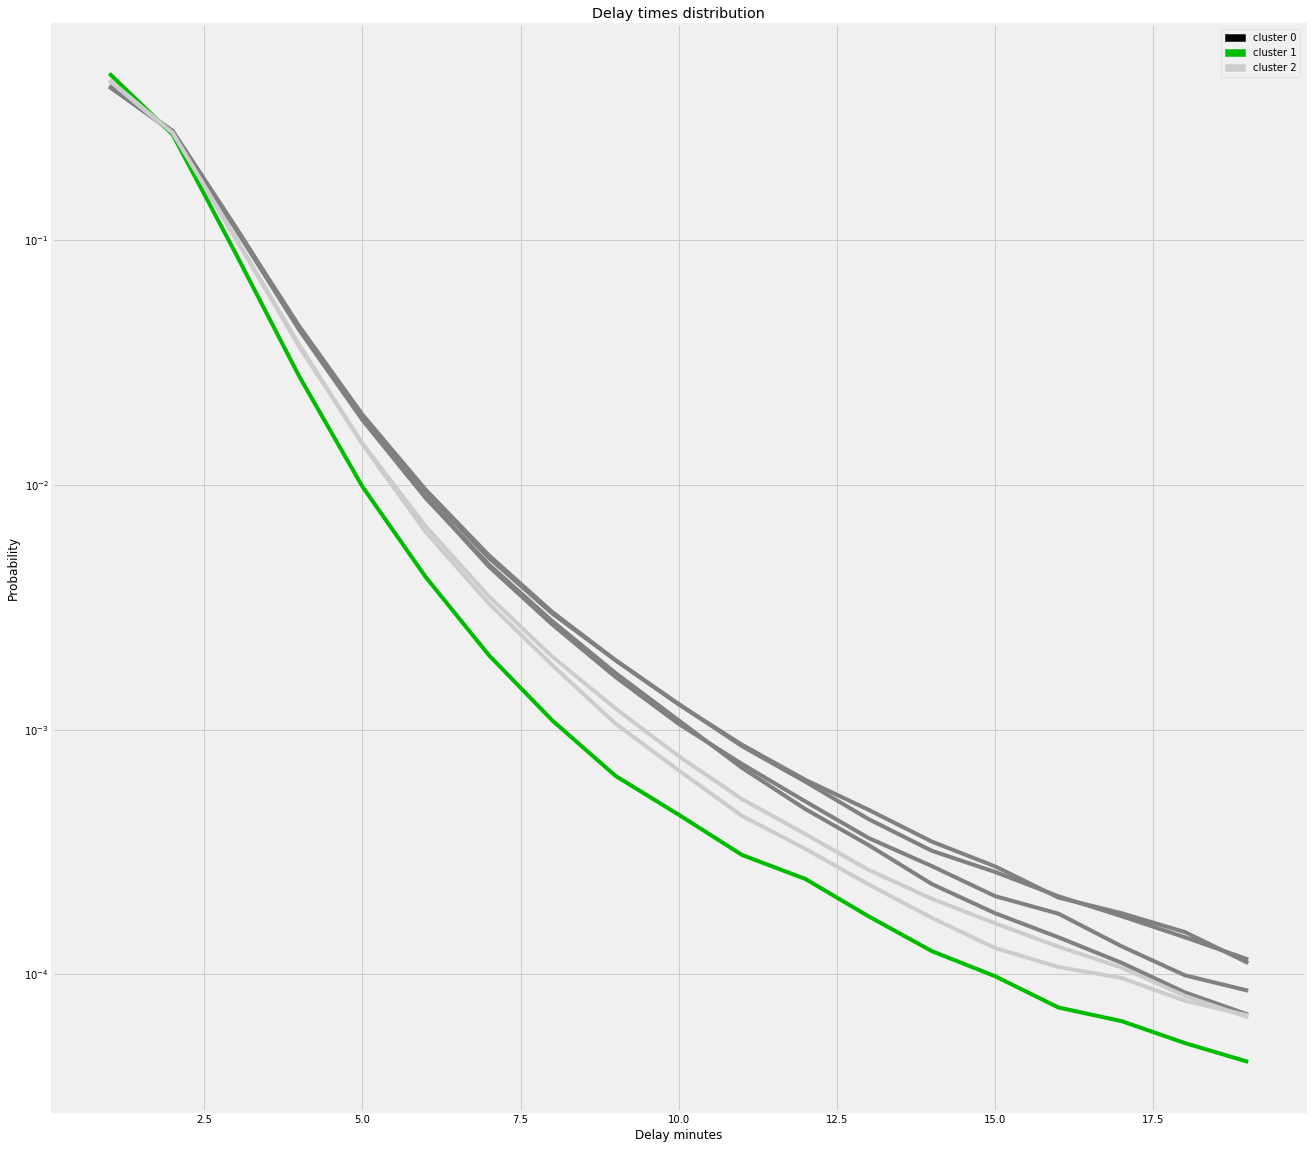

In [40]:
plot_delay_distribution_and_predict_depart(COLUMN_NAME='ACTUAL_DEPART_TIME_week_day', clusters_num=3, legend=True)

---